In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
from sklearn.base import clone


In [2]:
#Canonical_SMILES

In [3]:


# 读取数据
data = pd.read_csv("./imputed_selected_features_Toxcity.csv")
data = data.dropna()  # 删除缺失值
smiles_data = data['SMILES'].tolist()



In [4]:
import torch

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    print("CUDA 可用，GPU 可用。")
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"GPU 数量: {torch.cuda.device_count()}")
    print(f"当前设备名称: {torch.cuda.get_device_name(0)}")
    print(f"当前设备总内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA 不可用，仅支持 CPU。")


CUDA 可用，GPU 可用。
CUDA 版本: 12.1
GPU 数量: 1
当前设备名称: NVIDIA vGPU-32GB
当前设备总内存: 31.60 GB


In [5]:
labels=data['Toxicity'].tolist()

In [6]:
# 数据增强函数：简单的 SMILES 序列翻转
def augment_smiles(smiles):
    """简单的数据增强方法，例如旋转 SMILES 字符串"""
    if random.random() > 0.5:
        return smiles[::-1]  # 翻转字符串
    return smiles


class SMILES_Dataset(torch.utils.data.Dataset):
    def __init__(self, smiles_list, class_labels, tokenizer):
        self.smiles = smiles_list
        self.class_labels = class_labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        class_label = self.class_labels[idx]
        tokens = self.tokenizer(smiles, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return tokens, torch.tensor(class_label, dtype=torch.long)




class ChemBERTa_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ChemBERTa_Classifier, self).__init__()
        # 加载预训练的ChemBERTa模型
        self.chemberta = chemberta_model  # 假设chemberta_model已定义
        hidden_size = self.chemberta.config.hidden_size  # 一般为768

        # 分类任务的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, tokens):
        output = self.chemberta(**tokens)
        cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token 嵌入
        class_output = self.classifier(cls_embedding)  # 分类任务输出
        return class_output

In [7]:
import selfies as sf
from transformers import PreTrainedTokenizer
import torch

class SelfiesTokenizer(PreTrainedTokenizer):
    def __init__(self, vocab=None, **kwargs):
        if vocab is None:
            vocab = []
        self.vocab = vocab
        self.vocab_dict = {word: idx for idx, word in enumerate(self.vocab)}
        self.inv_vocab_dict = {idx: word for word, idx in self.vocab_dict.items()}
        super().__init__(**kwargs)
        # 设置特殊 token，注意这些值必须在词表中
        self._pad_token = "[PAD]" if "[PAD]" in self.vocab_dict else None
        self._cls_token = "[CLS]" if "[CLS]" in self.vocab_dict else None
        self._sep_token = "[SEP]" if "[SEP]" in self.vocab_dict else None
        self._unk_token = "[UNK]" if "[UNK]" in self.vocab_dict else None
        self._mask_token = "[MASK]" if "[MASK]" in self.vocab_dict else None

    @property
    def pad_token(self):
        return self._pad_token

    @pad_token.setter
    def pad_token(self, value):
        self._pad_token = value

    @property
    def pad_token_id(self):
        if self._pad_token is None:
            return None
        return self.vocab_dict.get(self._pad_token, None)

    def get_vocab(self):
        return self.vocab_dict

    @property
    def vocab_size(self):
        return len(self.vocab_dict)

    def add_special_tokens(self, special_tokens_dict):
        added = 0
        for token_name, token_str in special_tokens_dict.items():
            if token_str not in self.vocab_dict:
                idx = len(self.vocab_dict)
                self.vocab_dict[token_str] = idx
                self.inv_vocab_dict[idx] = token_str
                added += 1
            if token_name == "pad_token":
                self._pad_token = token_str
            elif token_name == "cls_token":
                self._cls_token = token_str
            elif token_name == "sep_token":
                self._sep_token = token_str
            elif token_name == "unk_token":
                self._unk_token = token_str
            elif token_name == "mask_token":
                self._mask_token = token_str
        return added

    def _tokenize(self, text):
        """内部分词逻辑：将 SMILES 转换为 SELFIES，然后拆分为 token 列表"""
        selfies_str = sf.encoder(text)
        tokens = list(sf.split_selfies(selfies_str))
        return tokens

    def tokenize(self, text, **kwargs):
        # 兼容 transformers 可能传入的额外参数
        return self._tokenize(text)

    def _convert_token_to_id(self, token):
        return self.vocab_dict.get(token, self.vocab_dict.get("[UNK]", 0))

    def _convert_id_to_token(self, index):
        return self.inv_vocab_dict.get(index, "[UNK]")

    def convert_tokens_to_ids(self, tokens):
        return [self._convert_token_to_id(token) for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self._convert_id_to_token(idx) for idx in ids]

    def encode(self, text, add_special_tokens=True):
        tokens = self.tokenize(text)
        token_ids = self.convert_tokens_to_ids(tokens)
        if add_special_tokens:
            if self._cls_token is not None:
                token_ids = [self._convert_token_to_id(self._cls_token)] + token_ids
            if self._sep_token is not None:
                token_ids.append(self._convert_token_to_id(self._sep_token))
        return torch.tensor(token_ids, dtype=torch.long)

    def decode(self, token_ids):
        tokens = self.convert_ids_to_tokens(token_ids)
        return "".join(tokens)

    def __call__(self, text, padding='max_length', truncation=True, max_length=128, return_tensors='pt'):
        # 调用 encode 得到 token_ids
        token_ids = self.encode(text, add_special_tokens=True).tolist()
        # 处理 truncation/padding
        if truncation and len(token_ids) > max_length:
            token_ids = token_ids[:max_length]
        if padding == "max_length":
            token_ids = token_ids + [self.pad_token_id] * (max_length - len(token_ids))
        attention_mask = [1 if tid != self.pad_token_id else 0 for tid in token_ids]
        if return_tensors == "pt":
            return {
                "input_ids": torch.tensor([token_ids], dtype=torch.long),
                "attention_mask": torch.tensor([attention_mask], dtype=torch.long)
            }
        else:
            return {"input_ids": token_ids, "attention_mask": attention_mask}

# --- 测试自定义 Tokenizer ---
import selfies as sf
base_vocab = ["[CLS]", "[SEP]", "[PAD]", "[MASK]", "[UNK]"] + list(sf.get_semantic_robust_alphabet())
tokenizer = SelfiesTokenizer(base_vocab)
tokenizer.add_special_tokens({
    "pad_token": "[PAD]",
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "mask_token": "[MASK]"
})

# 测试 __call__
smiles_example = "CC(Cl)Br"
encoding = tokenizer(smiles_example, padding='max_length', truncation=True, max_length=10, return_tensors="pt")
print("Encoding result:", encoding)


# # **1. 定义 SELFIES 词表**
# selfies_vocab = ["[CLS]", "[SEP]", "[PAD]", "[MASK]", "[UNK]"] + list(sf.get_semantic_robust_alphabet())

# # **2. 创建 SELFIES Tokenizer**
# selfies_tokenizer = SelfiesTokenizer(selfies_vocab)

# # **3. 测试 SELFIES Tokenizer**
# smiles_example = "O=[N+]([O-])OCC(CO[N+](=O)[O-])O[N+](=O)[O-]"
# tokens = selfies_tokenizer.tokenize(smiles_example)
# print("SELFIES Tokenized:", tokens)

# # **4. 将 SELFIES Token 转换为 ID**
# token_ids = selfies_tokenizer.encode(smiles_example)
# print("Token IDs:", token_ids)

# # **5. 解码回 SELFIES**
# decoded_selfies = selfies_tokenizer.decode(token_ids.tolist())
# print("Decoded SELFIES:", decoded_selfies)



Encoding result: {'input_ids': tensor([[ 0, 11, 11, 41, 11, 23, 27,  1,  2,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])}


In [8]:
# 加载 ChemBERTa 模型和 tokenizer
model_name = "../ChemBERTa"
#tokenizer = RobertaTokenizer.from_pretrained(model_name)

#tokenizer = SelfiesTokenizer(base_vocab)
chemberta_model = RobertaModel.from_pretrained(model_name)

In [9]:
import selfies as sf
base_vocab = ["[CLS]", "[SEP]", "[PAD]", "[MASK]", "[UNK]"] + list(sf.get_semantic_robust_alphabet())
tokenizer_instance = SelfiesTokenizer(base_vocab)
tokenizer_instance.add_special_tokens({
    "pad_token": "[PAD]",
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "mask_token": "[MASK]"
})
dataset = SMILES_Dataset(smiles_data, labels, tokenizer_instance)

In [9]:
from torch.utils.data import DataLoader, random_split
import torch



# 加载数据集
#dataset = SMILES_Dataset(smiles_data, labels,tokenizer)  # 只传入SMILES和分类标签

# 数据集划分：80%训练集，20%验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, drop_last=True)


In [10]:
# 假设 num_classes 已经定义，表示分类任务的类别数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用类别数来初始化分类器模型
model = ChemBERTa_Classifier(num_classes=2).to(device) 

Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 10.90it/s, Class Loss=0.669]


Epoch [1/50], Train Class Loss: 0.7846, Train Accuracy: 0.4798


Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 38.54it/s]


Epoch [1/50], Val Class Loss: 0.7331, Val Accuracy: 0.4375


Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.45it/s, Class Loss=0.669]


Epoch [2/50], Train Class Loss: 0.7393, Train Accuracy: 0.5331


Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 40.06it/s]


Epoch [2/50], Val Class Loss: 0.6694, Val Accuracy: 0.6406


Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.43it/s, Class Loss=0.878]


Epoch [3/50], Train Class Loss: 0.7166, Train Accuracy: 0.5478


Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.32it/s]


Epoch [3/50], Val Class Loss: 0.6994, Val Accuracy: 0.5156


Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.60it/s, Class Loss=0.733]


Epoch [4/50], Train Class Loss: 0.7015, Train Accuracy: 0.5404


Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 40.53it/s]


Epoch [4/50], Val Class Loss: 0.6456, Val Accuracy: 0.6172


Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.60it/s, Class Loss=0.796]


Epoch [5/50], Train Class Loss: 0.7022, Train Accuracy: 0.5864


Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.37it/s]


Epoch [5/50], Val Class Loss: 0.6274, Val Accuracy: 0.6719


Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.7]  


Epoch [6/50], Train Class Loss: 0.6816, Train Accuracy: 0.6158


Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.66it/s]


Epoch [6/50], Val Class Loss: 0.6599, Val Accuracy: 0.6094


Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.684]


Epoch [7/50], Train Class Loss: 0.6561, Train Accuracy: 0.6305


Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.33it/s]


Epoch [7/50], Val Class Loss: 0.6572, Val Accuracy: 0.6641


Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s, Class Loss=0.719]


Epoch [8/50], Train Class Loss: 0.6678, Train Accuracy: 0.6066


Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.14it/s]


Epoch [8/50], Val Class Loss: 0.6449, Val Accuracy: 0.6797


Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.672]


Epoch [9/50], Train Class Loss: 0.6521, Train Accuracy: 0.6360


Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.55it/s]


Epoch [9/50], Val Class Loss: 0.7022, Val Accuracy: 0.6094


Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.633]


Epoch [10/50], Train Class Loss: 0.6407, Train Accuracy: 0.6342


Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.74it/s]


Epoch [10/50], Val Class Loss: 0.6587, Val Accuracy: 0.6719


Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.654]


Epoch [11/50], Train Class Loss: 0.6073, Train Accuracy: 0.6801


Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 42.53it/s]


Epoch [11/50], Val Class Loss: 0.6300, Val Accuracy: 0.7031


Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.89it/s, Class Loss=0.566]


Epoch [12/50], Train Class Loss: 0.6183, Train Accuracy: 0.6507


Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 40.14it/s]


Epoch [12/50], Val Class Loss: 0.6837, Val Accuracy: 0.6484


Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.10it/s, Class Loss=0.61] 


Epoch [13/50], Train Class Loss: 0.6009, Train Accuracy: 0.6949


Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.79it/s]


Epoch [13/50], Val Class Loss: 0.6636, Val Accuracy: 0.6719


Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.598]


Epoch [14/50], Train Class Loss: 0.6040, Train Accuracy: 0.6636


Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.89it/s]


Epoch [14/50], Val Class Loss: 0.6358, Val Accuracy: 0.7266


Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.423]


Epoch [15/50], Train Class Loss: 0.5626, Train Accuracy: 0.7188


Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.41it/s]


Epoch [15/50], Val Class Loss: 0.5833, Val Accuracy: 0.7812


Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.11it/s, Class Loss=0.405]


Epoch [16/50], Train Class Loss: 0.5658, Train Accuracy: 0.7243


Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.69it/s]


Epoch [16/50], Val Class Loss: 0.6915, Val Accuracy: 0.6641


Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.658]


Epoch [17/50], Train Class Loss: 0.5457, Train Accuracy: 0.7353


Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.35it/s]


Epoch [17/50], Val Class Loss: 0.5293, Val Accuracy: 0.7891


Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.75it/s, Class Loss=0.466]


Epoch [18/50], Train Class Loss: 0.5330, Train Accuracy: 0.7335


Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.24it/s]


Epoch [18/50], Val Class Loss: 0.7360, Val Accuracy: 0.6953


Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.56it/s, Class Loss=0.564]


Epoch [19/50], Train Class Loss: 0.5227, Train Accuracy: 0.7592


Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 40.10it/s]


Epoch [19/50], Val Class Loss: 0.5775, Val Accuracy: 0.7812


Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.87it/s, Class Loss=0.515]


Epoch [20/50], Train Class Loss: 0.4979, Train Accuracy: 0.7776


Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.70it/s]


Epoch [20/50], Val Class Loss: 0.7844, Val Accuracy: 0.7500


Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.522]


Epoch [21/50], Train Class Loss: 0.4634, Train Accuracy: 0.8162


Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.49it/s]


Epoch [21/50], Val Class Loss: 0.5731, Val Accuracy: 0.7969


Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.50it/s, Class Loss=0.206]


Epoch [22/50], Train Class Loss: 0.4531, Train Accuracy: 0.8382


Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.25it/s]


Epoch [22/50], Val Class Loss: 0.6999, Val Accuracy: 0.7891


Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.76it/s, Class Loss=0.258]


Epoch [23/50], Train Class Loss: 0.4133, Train Accuracy: 0.8511


Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.00it/s]


Epoch [23/50], Val Class Loss: 0.7739, Val Accuracy: 0.7891


Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.612]


Epoch [24/50], Train Class Loss: 0.3973, Train Accuracy: 0.8640


Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.63it/s]


Epoch [24/50], Val Class Loss: 0.4478, Val Accuracy: 0.8672


Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.44it/s, Class Loss=0.407]


Epoch [25/50], Train Class Loss: 0.3906, Train Accuracy: 0.8493


Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.08it/s]


Epoch [25/50], Val Class Loss: 0.7641, Val Accuracy: 0.8125


Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.00it/s, Class Loss=0.61] 


Epoch [26/50], Train Class Loss: 0.3638, Train Accuracy: 0.8750


Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 40.09it/s]


Epoch [26/50], Val Class Loss: 0.9429, Val Accuracy: 0.8203


Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.44it/s, Class Loss=0.233]


Epoch [27/50], Train Class Loss: 0.3128, Train Accuracy: 0.8971


Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.15it/s]


Epoch [27/50], Val Class Loss: 0.9447, Val Accuracy: 0.8047


Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.11it/s, Class Loss=0.367] 


Epoch [28/50], Train Class Loss: 0.2835, Train Accuracy: 0.9118


Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.65it/s]


Epoch [28/50], Val Class Loss: 1.1162, Val Accuracy: 0.8203


Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.358]


Epoch [29/50], Train Class Loss: 0.2883, Train Accuracy: 0.9136


Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.49it/s]


Epoch [29/50], Val Class Loss: 1.2173, Val Accuracy: 0.8125


Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.223]


Epoch [30/50], Train Class Loss: 0.3344, Train Accuracy: 0.8989


Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.38it/s]


Epoch [30/50], Val Class Loss: 0.6092, Val Accuracy: 0.8750


Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.09it/s, Class Loss=0.934] 


Epoch [31/50], Train Class Loss: 0.2896, Train Accuracy: 0.9099


Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.22it/s]


Epoch [31/50], Val Class Loss: 1.3536, Val Accuracy: 0.8359


Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.49it/s, Class Loss=0.154]


Epoch [32/50], Train Class Loss: 0.2510, Train Accuracy: 0.9265


Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.10it/s]


Epoch [32/50], Val Class Loss: 1.0765, Val Accuracy: 0.8438


Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.41it/s, Class Loss=0.1]   


Epoch [33/50], Train Class Loss: 0.1962, Train Accuracy: 0.9467


Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.14it/s]


Epoch [33/50], Val Class Loss: 1.1842, Val Accuracy: 0.8438


Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.54it/s, Class Loss=0.203] 


Epoch [34/50], Train Class Loss: 0.2227, Train Accuracy: 0.9430


Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.22it/s]


Epoch [34/50], Val Class Loss: 0.7828, Val Accuracy: 0.8672


Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.41it/s, Class Loss=0.207]


Epoch [35/50], Train Class Loss: 0.2143, Train Accuracy: 0.9393


Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.65it/s]


Epoch [35/50], Val Class Loss: 1.9424, Val Accuracy: 0.7812


Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.13it/s, Class Loss=0.26]  


Epoch [36/50], Train Class Loss: 0.2521, Train Accuracy: 0.9099


Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.79it/s]


Epoch [36/50], Val Class Loss: 0.7373, Val Accuracy: 0.8750


Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.275] 


Epoch [37/50], Train Class Loss: 0.1981, Train Accuracy: 0.9449


Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.80it/s]


Epoch [37/50], Val Class Loss: 1.2060, Val Accuracy: 0.8281


Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.231]


Epoch [38/50], Train Class Loss: 0.2189, Train Accuracy: 0.9393


Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.97it/s]


Epoch [38/50], Val Class Loss: 1.0745, Val Accuracy: 0.8281


Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.44it/s, Class Loss=0.101]


Epoch [39/50], Train Class Loss: 0.1846, Train Accuracy: 0.9596


Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.35it/s]


Epoch [39/50], Val Class Loss: 1.5177, Val Accuracy: 0.7969


Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.121] 


Epoch [40/50], Train Class Loss: 0.1969, Train Accuracy: 0.9430


Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.53it/s]


Epoch [40/50], Val Class Loss: 1.2431, Val Accuracy: 0.8203


Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.118]


Epoch [41/50], Train Class Loss: 0.1509, Train Accuracy: 0.9632


Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.11it/s]


Epoch [41/50], Val Class Loss: 1.4728, Val Accuracy: 0.8047


Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.46it/s, Class Loss=0.198] 


Epoch [42/50], Train Class Loss: 0.2151, Train Accuracy: 0.9210


Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.96it/s]


Epoch [42/50], Val Class Loss: 1.3005, Val Accuracy: 0.8438


Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.46it/s, Class Loss=0.0336]


Epoch [43/50], Train Class Loss: 0.2025, Train Accuracy: 0.9283


Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.09it/s]


Epoch [43/50], Val Class Loss: 1.4802, Val Accuracy: 0.8203


Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.46it/s, Class Loss=0.0504]


Epoch [44/50], Train Class Loss: 0.1788, Train Accuracy: 0.9485


Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 38.94it/s]


Epoch [44/50], Val Class Loss: 1.9587, Val Accuracy: 0.7891


Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.46it/s, Class Loss=0.727] 


Epoch [45/50], Train Class Loss: 0.2054, Train Accuracy: 0.9338


Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.97it/s]


Epoch [45/50], Val Class Loss: 1.3093, Val Accuracy: 0.8359


Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 15.42it/s, Class Loss=0.184] 


Epoch [46/50], Train Class Loss: 0.1420, Train Accuracy: 0.9669


Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 39.47it/s]


Epoch [46/50], Val Class Loss: 2.0459, Val Accuracy: 0.8047


Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.38it/s, Class Loss=0.258] 


Epoch [47/50], Train Class Loss: 0.1319, Train Accuracy: 0.9614


Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.47it/s]


Epoch [47/50], Val Class Loss: 1.5776, Val Accuracy: 0.8125


Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.149] 


Epoch [48/50], Train Class Loss: 0.1358, Train Accuracy: 0.9504


Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.67it/s]


Epoch [48/50], Val Class Loss: 1.3538, Val Accuracy: 0.8281


Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.46it/s, Class Loss=0.0379]


Epoch [49/50], Train Class Loss: 0.1462, Train Accuracy: 0.9540


Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.25it/s]


Epoch [49/50], Val Class Loss: 1.0266, Val Accuracy: 0.8438


Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.134] 


Epoch [50/50], Train Class Loss: 0.1951, Train Accuracy: 0.9614


Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 47.16it/s]


Epoch [50/50], Val Class Loss: 1.1673, Val Accuracy: 0.8594


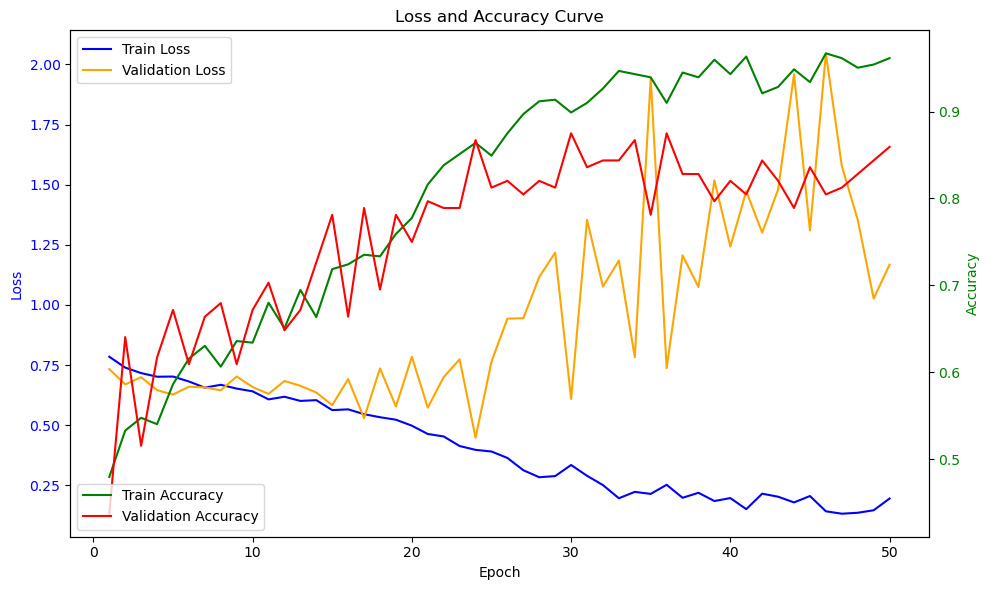

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn as nn

# 分类任务的损失函数
class_criterion = nn.CrossEntropyLoss()  # 分类任务的损失

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# 训练模型
num_epochs = 50

# 记录损失和准确率
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_class_loss = 0.0
    correct_class_preds = 0
    total_class_preds = 0
    
    # 使用 tqdm 包装 train_loader
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    for tokens, class_labels in train_loader_tqdm:
        tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
        class_labels = class_labels.to(device)

        # 前向传播
        optimizer.zero_grad()
        class_output = model(tokens)

        # 计算分类任务的损失
        class_loss = class_criterion(class_output, class_labels)
        class_loss.backward()
        optimizer.step()

        running_class_loss += class_loss.item()

        # 计算分类准确率
        _, predicted = torch.max(class_output, 1)
        correct_class_preds += (predicted == class_labels).sum().item()
        total_class_preds += class_labels.size(0)

        # 在 tqdm 显示分类损失
        train_loader_tqdm.set_postfix({'Class Loss': class_loss.item()})

    avg_class_loss = running_class_loss / len(train_loader)
    train_accuracy = correct_class_preds / total_class_preds
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Class Loss: {avg_class_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # 保存训练损失和准确率
    train_losses.append(avg_class_loss)
    train_accuracies.append(train_accuracy)

    # 验证模型
    model.eval()
    val_class_loss = 0.0
    correct_class_preds = 0
    total_class_preds = 0
    all_preds = []
    all_labels = []
    
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation")
    with torch.no_grad():
        for tokens, class_labels in val_loader_tqdm:
            tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
            class_labels = class_labels.to(device)

            # 前向传播
            class_output = model(tokens)

            # 计算分类任务的损失
            class_loss = class_criterion(class_output, class_labels)
            val_class_loss += class_loss.item()

            # 计算分类准确率
            _, predicted = torch.max(class_output, 1)
            correct_class_preds += (predicted == class_labels).sum().item()
            total_class_preds += class_labels.size(0)

        avg_val_class_loss = val_class_loss / len(val_loader)
        val_accuracy = correct_class_preds / total_class_preds
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Class Loss: {avg_val_class_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # 保存验证损失和准确率
        val_losses.append(avg_val_class_loss)
        val_accuracies.append(val_accuracy)

import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制损失曲线
ax1 = plt.gca()  # 获取当前坐标轴
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')  # 设置y轴的刻度颜色
ax1.set_title('Loss and Accuracy Curve')

# 创建第二个y轴来绘制准确率曲线
ax2 = ax1.twinx()  # 创建第二个Y轴共享X轴
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')  # 设置y轴的刻度颜色

# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

# 显示图形
plt.tight_layout()
plt.show()


In [11]:
# 加载最佳模型
model.load_state_dict(torch.load('./best_chemberta_model.pth'))

<All keys matched successfully>

In [12]:
import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt

def compute_self_attention_weights(smiles, model, tokenizer, device, max_length=128):
    encoding = tokenizer(smiles, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    encoding = {key: val.to(device) for key, val in encoding.items()}
    
    outputs = model.chemberta(**encoding, output_attentions=True)
    attentions = outputs.attentions[-1]  # 取最后一层注意力
    avg_attention = attentions.mean(dim=1)
    cls_attention = avg_attention[0, 0, :]  # [CLS] 对所有 token 的注意力
    
    # **打印实际 Token 数量**
    #print(f"Input IDs Shape: {encoding['input_ids'].shape}")
    #print(f"Attention Weights Shape: {cls_attention.shape}")
    
    # **去除特殊 token**
    valid_tokens = [t for t in tokenizer.tokenize(smiles) if t not in ["[CLS]", "[SEP]", "[PAD]"]]
    token_weights = cls_attention[1:len(valid_tokens) + 1].cpu().detach().numpy()
    
    return valid_tokens, token_weights

def visualize_attention(smiles, tokens, weights, highlight_percent=20, image_size=(300,300)):
    """
    绘制分子结构，并将自注意力权重最高的 highlight_percent% 原子标记为红色。
    
    参数：
        smiles: SMILES 字符串
        tokens: SELFIES 分词结果列表（不包含特殊 token）
        weights: 对应每个 token 的注意力权重（numpy 数组）
        highlight_percent: 要高亮的比例（例如 20 表示高亮权重最高 20% 的原子）
        image_size: 绘图大小
    """
    # 解析 SMILES 得到 RDKit 分子对象
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("无法解析 SMILES:", smiles)
        return
    
    num_atoms = mol.GetNumAtoms()
    if len(tokens) != num_atoms:
        print("警告：SELFIES tokens 数量（{}）与 RDKit 原子数（{}）不匹配！".format(len(tokens), num_atoms))
        # 取二者最小值进行映射
        n = min(len(tokens), num_atoms)
    else:
        n = num_atoms

    # 计算权重阈值：选取最高的 highlight_percent% 权重
    threshold = np.percentile(weights, 100 - highlight_percent)
    # 找到权重高于阈值的 token 对应的原子索引（假设顺序一致）
    highlight_atoms = [i for i, w in enumerate(weights[:n]) if w >= threshold]
    
    # 定义高亮颜色：红色
    highlight_colors = {atom_idx: (1.0, 0.0, 0.0) for atom_idx in highlight_atoms}
    
    # 使用 RDKit 绘图
    drawer = rdMolDraw2D.MolDraw2DCairo(image_size[0], image_size[1])
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    png_data = drawer.GetDrawingText()
    
    # 保存并显示图片
    with open("molecule_attention.png", "wb") as f:
        f.write(png_data)
    
    img = plt.imread("molecule_attention.png")
    plt.figure(figsize=(4,4),dpi=500)
    plt.imshow(img)
    plt.axis("off")
    plt.show()




In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# from io import BytesIO
# from PIL import Image
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import rdMolDraw2D

# def visualize_attention(smiles, atom_weights, save_path=None):
#     """
#     绘制分子结构，并用颜色显示每个原子的注意力权重。
    
#     参数:
#         smiles (str): 分子的 SMILES 结构
#         atom_weights (list): 每个原子的注意力权重（应与分子中的原子数量一致）
#         save_path (str, optional): 如果提供，则保存图像
#     """
#     # 解析 SMILES 并检查原子数量
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         raise ValueError("无效的 SMILES 结构")
#     num_atoms = mol.GetNumAtoms()
    
#     if len(atom_weights) != num_atoms:
#         raise ValueError(f"注意力权重数量 ({len(atom_weights)}) 与原子数量 ({num_atoms}) 不匹配")

#     # 归一化权重（0~1之间）
#     norm_weights = np.array(atom_weights)
#     norm_weights = (norm_weights - norm_weights.min()) / (norm_weights.max() - norm_weights.min() + 1e-6)

#     # 定义颜色映射（红色高，灰色低）
#     atom_colors = {i: (1, 1-norm_weights[i], 1-norm_weights[i]) for i in range(num_atoms)}

#     # RDKit 可视化
#     drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)  # 500x500 分辨率
#     drawer.drawOptions().atomHighlightsAreCircles = True
#     drawer.drawOptions().highlightColor = (1.0, 0.5, 0.5)

#     # 高亮原子
#     atom_radii = {i: 0.3 + norm_weights[i] * 0.3 for i in range(num_atoms)}  # 半径随权重变化
#     Chem.rdDepictor.Compute2DCoords(mol)
#     drawer.DrawMolecule(mol, highlightAtoms=list(atom_colors.keys()), highlightAtomColors=atom_colors, highlightAtomRadii=atom_radii)
#     drawer.FinishDrawing()
    
#     # 获取 RDKit 生成的二进制图像数据
#     img_bytes = drawer.GetDrawingText()

#     # 用 PIL 读取二进制图像数据
#     img = Image.open(BytesIO(img_bytes))

#     # 显示或保存图像
#     if save_path:
#         img.save(save_path)
#     else:
#         plt.figure(figsize=(5, 5))
#         plt.imshow(img)
#         plt.axis("off")
#         plt.show()


# # ✅ 示例使用
# smiles_example = "CC(=O)Oc1ccccc1C(=O)O"
# attention_weights = [0.1, 0.3, 0.8, 0.6, 0.2, 0.7, 0.5, 0.3, 0.9, 0.4, 0.2, 0.1,0.2]  # 假设的注意力权重
# visualize_attention(smiles_example, attention_weights)


In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import rdMolDraw2D
# from io import BytesIO
# from PIL import Image

# def visualize_molecule_with_heatmap(smiles, atom_weights, save_path=None):
#     """
#     绘制分子 2D 结构，并在上方显示注意力权重的热力图。
    
#     参数:
#         smiles (str): 分子的 SMILES 结构
#         atom_weights (list): 每个原子的注意力权重（长度应与 SMILES 中的原子数一致）
#         save_path (str, optional): 如果提供，将保存图片
#     """
#     # 解析 SMILES 结构
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         raise ValueError("无效的 SMILES 结构")
    
#     num_atoms = mol.GetNumAtoms()
    
#     if len(atom_weights) != num_atoms:
#         raise ValueError(f"注意力权重数量 ({len(atom_weights)}) 与原子数量 ({num_atoms}) 不匹配")

#     # 归一化权重（0~1之间）
#     norm_weights = np.array(atom_weights)
#     norm_weights = (norm_weights - norm_weights.min()) / (norm_weights.max() - norm_weights.min() + 1e-6)

#     # 创建热力图数据
#     atom_indices = np.arange(num_atoms).reshape(1, -1)  # 1 行 N 列
#     weight_matrix = np.array(norm_weights).reshape(1, -1)  # 1 行 N 列

#     # 设置颜色映射（红色高，灰色低）
#     atom_colors = {i: (1, 1-norm_weights[i], 1-norm_weights[i]) for i in range(num_atoms)}

#     # 画布布局
#     fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})

#     # (1) 绘制热力图
#     sns.heatmap(weight_matrix, annot=True, cmap="Reds", cbar=False, xticklabels=atom_indices.flatten(), yticklabels=["Weight"], ax=axes[0])
#     axes[0].set_xticklabels(axes[0].get_xticks(), rotation=0)  # 让 X 轴刻度水平
#     axes[0].set_yticklabels(["Weight"], rotation=0)  # Y 轴保持水平
#     axes[0].set_xlabel("原子编号")
    
#     # (2) RDKit 可视化
#     drawer = rdMolDraw2D.MolDraw2DCairo(500, 300)
#     drawer.drawOptions().atomHighlightsAreCircles = True
#     drawer.drawOptions().highlightColor = (1.0, 0.5, 0.5)

#     atom_radii = {i: 0.5 + norm_weights[i] * 0.5 for i in range(num_atoms)}
#     Chem.rdDepictor.Compute2DCoords(mol)
#     drawer.DrawMolecule(mol, highlightAtoms=list(atom_colors.keys()), highlightAtomColors=atom_colors, highlightAtomRadii=atom_radii)
#     drawer.FinishDrawing()
    
#     # 读取 RDKit 生成的图像
#     img_bytes = drawer.GetDrawingText()
#     img = Image.open(BytesIO(img_bytes))
    
#     # 在 Matplotlib 画布上绘制 RDKit 图像
#     axes[1].imshow(img)
#     axes[1].axis("off")

#     # 显示或保存
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight', dpi=300)
#     else:
#         plt.show()

# # ✅ 示例使用
# smiles_example = "CC(=O)Oc1ccccc1C(=O)O"
# tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
# visualize_molecule_with_heatmap(smiles_example, weights)


In [50]:
# 由于代码执行状态重置，需要重新导入必要的库并重新定义数据

from collections import defaultdict
import numpy as np
import pandas as pd




import selfies as sf
from rdkit import Chem
import numpy as np

def map_selfies_tokens_to_atoms(tokens):
    """
    尝试将 SELFIES Token 映射到“真实原子”的索引。
    返回一个列表 atom_map，长度与 tokens 相同，atom_map[i] = 对应的“真实原子ID”。
    如果某 token 是分支/环符号，则 atom_map[i] = -1。
    
    说明：
      - 我们用一个栈/上下文来追踪当前“活跃原子”以及分支/环连接。
      - 当出现 [BranchX] 或 [RingX] 时，可能导致重复写法，需要合并。
      - 这是一个“最大努力”的通用算法，若遇到极端复杂结构，可能需要更完善的解析。
    """

    # 定义要忽略的结构符
    branch_symbols = {"[Branch1]", "[Branch2]", "[Branch3]", "[Branch4]"}
    ring_symbols   = {"[Ring1]", "[Ring2]", "[Ring3]", "[Ring4]", "[Ring5]"}
    structure_symbols = branch_symbols.union(ring_symbols)

    # 判断是否“真实原子”Token（非常简化判断：只要不在 structure_symbols，并且以"["开头以"]"结尾）
    def is_real_atom(tok):
        return (tok.startswith("[") and tok.endswith("]") and tok not in structure_symbols)

    # 下述变量辅助我们做一个简易的解析
    current_atom_id = -1   # 当前原子ID
    atom_map = [-1] * len(tokens)  # 默认 -1
    # stack 用于分支回溯
    # ring_dict 用于环闭合 (ring_id -> atom_id)
    ring_dict = {}

    # last_atom_id：记录我们“最近一次出现的原子”ID，用于分支/环指向
    last_atom_id = None
    # real_atoms 统计出现的“真实原子”的次数
    # 这里我们并不一定知道它和 RDKit 原子index对应，但先做一个内部ID
    # (后面会再做对齐)
    real_atom_count = 0

    # atom_alias：若我们确认两个 token 指向同一个真实原子，则合并别名
    # atom_alias[a] = b 表示 “a 的真实ID” = “b 的真实ID”
    # 最后我们会做一次 union-find 压缩
    atom_alias = {}

    def find_alias(a):
        # union-find find
        while atom_alias.get(a, a) != a:
            a = atom_alias[a]
        return a

    def union_alias(a, b):
        ra, rb = find_alias(a), find_alias(b)
        if ra != rb:
            atom_alias[rb] = ra

    for i, tok in enumerate(tokens):
        if tok in structure_symbols:
            # 分支/环符号
            atom_map[i] = -1
            if tok in branch_symbols:
                # 分支符号：下一个原子可能与 last_atom_id 合并
                # 这里不做任何操作，等待下一个 real_atom
                pass
            else:
                # 环符号
                ring_id = tok.strip("[]")  # "Ring1", "Ring2"...
                if ring_id not in ring_dict:
                    # 第一次出现 => 记录下 current_atom
                    ring_dict[ring_id] = last_atom_id
                else:
                    # 第二次出现 => 与 ring_dict[ring_id] 合并
                    # 表示当前原子和 ring_dict[ring_id] 是同一个
                    if last_atom_id is not None and ring_dict[ring_id] is not None:
                        union_alias(last_atom_id, ring_dict[ring_id])
            continue

        if is_real_atom(tok):
            # 新的(或重复的)原子
            current_atom_id += 1
            atom_map[i] = current_atom_id
            # last_atom_id -> current_atom_id 是否合并？
            # 在某些SELFIES语法中, “重复写法”可能紧跟分支符号
            # 这里先简单假设 “[BranchX] 后第一个原子” 可能要跟 last_atom_id 合并
            # 也可以做更多逻辑区分
            if last_atom_id is not None:
                # 可选: union_alias(current_atom_id, last_atom_id)
                pass
            last_atom_id = current_atom_id
        else:
            # 其他情况, 可能是 [=O], [C+1], [N-1], etc. 也算“原子” -> same logic
            # 这里简单处理
            current_atom_id += 1
            atom_map[i] = current_atom_id
            last_atom_id = current_atom_id

    # union-find 压缩
    # atom_map[i] = find_alias(atom_map[i]) if atom_map[i] != -1
    for i in range(len(atom_map)):
        aid = atom_map[i]
        if aid != -1:
            ra = find_alias(aid)
            atom_map[i] = ra

    return atom_map

def average_selfies_weights_any_case(tokens, weights):
    """
    1) 将 SELFIES tokens -> atom_map (可能有重复写法)
    2) 对相同 atom_id 的 token 权重取平均
    3) 返回按 atom_id 升序排列的平均权重列表 (仅限出现的 atom_id)
    """
    if len(tokens) != len(weights):
        raise ValueError("tokens 与 weights 长度不匹配！")

    atom_map = map_selfies_tokens_to_atoms(tokens)
    # 收集 atom_id -> [weights...]
    from collections import defaultdict
    weight_dict = defaultdict(list)

    max_id = -1
    for w, aid in zip(weights, atom_map):
        if aid >= 0:
            weight_dict[aid].append(w)
            if aid > max_id:
                max_id = aid

    # 对每个 atom_id 取平均
    # 并按 atom_id 顺序返回
    result = []
    for aid in range(max_id+1):
        wlist = weight_dict[aid]
        if len(wlist) == 0:
            result.append(0.0)
        else:
            result.append(sum(wlist)/len(wlist))
    return result

def get_atom_weights_for_smiles(selfies_tokens, selfies_weights):
    """
    一个更完整的示例:
    1) 将 token 列表拼接为 SELFIES 字符串
    2) decoder 得到 SMILES
    3) RDKit 解析 SMILES 得到真实原子数
    4) 用上面 average_selfies_weights_any_case 计算“合并后原子ID”的权重
    5) 若 SELFIES 解析出来的“最大 atom_id + 1” 与 RDKit 的实际原子数不符, 
       则做一个最简映射(截断 or 补零)
    
    返回: real_atom_weights, 长度 = RDKit 原子数. 
          real_atom_weights[i] = 该 i 号原子的注意力 (若不完全匹配, 近似处理)
    """
    # 1) 拼成 SELFIES 字符串
    selfies_str = "".join(selfies_tokens)  # 形如 "[C][C][Branch1]..."
    # 2) decoder
    decoded_smiles = sf.decoder(selfies_str)
    # 3) RDKit parse
    mol = Chem.MolFromSmiles(decoded_smiles)
    if mol is None:
        raise ValueError("无法从 SELFIES 解码到有效 SMILES:", decoded_smiles)
    num_atoms = mol.GetNumAtoms()

    # 4) 用 average_selfies_weights_any_case
    merged_weights = average_selfies_weights_any_case(selfies_tokens, selfies_weights)
    # 5) 如果 merged_weights 长度 < num_atoms, 则补零; 若 > num_atoms, 则截断
    if len(merged_weights) < num_atoms:
        merged_weights += [0.0]*(num_atoms - len(merged_weights))
    elif len(merged_weights) > num_atoms:
        merged_weights = merged_weights[:num_atoms]

    return merged_weights


# ================== 测试示例 ==================
if __name__ == "__main__":

    
    smiles = "CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC"  # 示例 SMILES
    tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
    
    attention_weights=weights
    selfies_tokens = tokens


    # 计算合并后的“原子ID”权重
    merged = average_selfies_weights_any_case(selfies_tokens, attention_weights)
    print("合并后原子ID的权重:", merged)
    # 可能输出: [0.12, 0.1833..., 0.09, 0.11], 代表 4 个原子

    # 测试 get_atom_weights_for_smiles (复杂情况)
    # 例如 tokens = ['[C]', '[C]', '[Branch1]', '[C]', '[O]', '[=O]', '[Branch1]', '[O]', '[H]', ...]
    # weights = [...]
    # real_atom_weights = get_atom_weights_for_smiles(tokens, weights)
    # print("映射到 RDKit 原子数:", real_atom_weights)



Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
合并后原子ID的权重: [np.float32(0.015524741), np.float32(0.014583404), np.float32(0.022031736), np.float32(0.022480002), 0.0, np.float32(0.016692813), np.float32(0.012377789), np.float32(0.008071112), np.float32(0.012528425), np.float32(0.014489464), np.float32(0.019528508), np.float32(0.031343207), np.float32(0.045050453), np.float32(0.012521466), np.float32(0.011069013), np.float32(0.031246543), np.float32(0.011875674), np.float32(0.092301846), 0.0, np.float32(0.015481425), np.float32(0.022765309), np.float32(0.019154405), np.float32(0.025243148), np.float32(0.057299793), np.float32(0.016471671), np.float32(0.034874063), np.float32(0.040759895), np.float32(0.04961575), np.float32(0.028632669), np.float32(0.025232082), np.float32(0.033719566), np.float32(0.024678884), np.float32(0.019399703)]


In [52]:
len(merged)

33

In [53]:
smiles="CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC"

In [54]:
# 解析 SMILES 得到 RDKit 分子对象
mol = Chem.MolFromSmiles(smiles)
num_atoms = mol.GetNumAtoms()
print(num_atoms)

28


In [ ]:
CC(C)OC1=CC=CC=C1OC(=O)NC"

In [15]:
smiles_example = "C=CCC1=CC2=C(C=C1)OCO2"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

#visualize_attention(smiles_example, tokens, weights, highlight_percent=0)

SELFIES Tokens: ['[C]', '[=C]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[Branch1]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[O]', '[C]', '[O]', '[Ring1]', '[#Branch1]']
Attention Weights: [0.05474625 0.04984044 0.04399385 0.09036927 0.07946412 0.04919712
 0.03887269 0.04937476 0.04643596 0.05862461 0.04992006 0.03117802
 0.01809972 0.03520453 0.04370838 0.05832542 0.05310933 0.06215935]


In [56]:
smiles_example = "CCCCCCCCCCCCC1=CC=CC=C1O"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)



Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
SELFIES Tokens: ['[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[O]']
Attention Weights: [0.01882912 0.01632923 0.02177425 0.03377151 0.03491916 0.0281645
 0.03718721 0.03553782 0.03976022 0.03984914 0.0504833  0.0245947
 0.04404916 0.01652934 0.14591625 0.009807   0.12065195 0.02642649
 0.06678537 0.07487821 0.05720275]


In [57]:
smiles_example = "CC(C)OC1=CC=CC=C1OC(=O)NC"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

#visualize_attention(smiles_example, tokens, weights, highlight_percent=0)


Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
SELFIES Tokens: ['[C]', '[C]', '[Branch1]', '[C]', '[C]', '[O]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[O]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]']
Attention Weights: [0.03571165 0.01995715 0.01121728 0.10458498 0.09958297 0.01833086
 0.05774568 0.01608692 0.10261108 0.01010939 0.12104731 0.01948428
 0.01915421 0.04268922 0.02737506 0.02732516 0.01897028 0.01601039
 0.0977759  0.01333856 0.05286257]


In [58]:
smiles_example = "C1=CC=C(C=C1)C(=O)O"  # 示例 SMILES
tokens, weights = compute_self_attention_weights(smiles_example, model, tokenizer_instance, device, max_length=128)
print("SELFIES Tokens:", tokens)
print("Attention Weights:", weights)

#visualize_attention(smiles_example, tokens, weights, highlight_percent=0)

Input IDs Shape: torch.Size([1, 128])
Attention Weights Shape: torch.Size([128])
SELFIES Tokens: ['[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[Branch1]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[C]', '[=Branch1]', '[C]', '[=O]', '[O]']
Attention Weights: [0.09808967 0.0541428  0.12435003 0.06854587 0.03368711 0.02685764
 0.17250788 0.06731035 0.03126104 0.0202319  0.04313722 0.02648165
 0.00878653 0.10272938 0.02238676]


In [20]:
from collections import defaultdict

def compute_dataset_average_weight_by_symbol(smiles_data, model, tokenizer, device):
    """
    对整个SMILES数据集，按原子符号区分，计算各符号的平均注意力权重。
    返回一个字典：{原子符号: 平均权重}
    """
    # 用字典记录每种原子符号的权重列表
    symbol_weights = defaultdict(list)

    for smiles in smiles_data:
        tokens, weights = compute_self_attention_weights(smiles, model, tokenizer, device)

        for t, w in zip(tokens, weights):
            # 过滤掉分支/环符号
            if t not in ["[Branch1]", "[Branch2]", "[Ring1]", "[Ring2]"]:
                symbol_weights[t].append(w)

    # 计算平均值
    avg_dict = {}
    for symbol, w_list in symbol_weights.items():
        if len(w_list) > 0:
            avg_dict[symbol] = sum(w_list) / len(w_list)
        else:
            avg_dict[symbol] = 0.0

    return avg_dict

# 示例调用
symbol_avg_dict = compute_dataset_average_weight_by_symbol(smiles_data, model, tokenizer_instance, device)
print("各原子符号的平均注意力权重:")
for sym, avg_w in symbol_avg_dict.items():
    print(sym, ":", avg_w)


各原子符号的平均注意力权重:
[C] : 0.07336026
[P] : 0.04085871
[O] : 0.06575617
[N+1] : 0.029231597
[=Branch1] : 0.05208654
[=O] : 0.12125614
[O-1] : 0.047443546
[=C] : 0.048272423
[#Branch1] : 0.08477676
[Cl] : 0.09894753
[#N] : 0.09054613
[N] : 0.07793074
[Br] : 0.14498705
[S] : 0.04854124
[=Branch2] : 0.06768385
[=N] : 0.06470954
[#Branch2] : 0.046178732
[#C] : 0.12415243
[=S] : 0.061400037
[F] : 0.06169526
[=N+1] : 0.015106926
[=N-1] : 0.02515692
. : 0.011437197


In [ ]:
[C] : 0.07336026
[P] : 0.04085871
[O] : 0.06575617
[N+1] : 0.029231597
[=Branch1] : 0.05208654
[=O] : 0.12125614
[O-1] : 0.047443546
[=C] : 0.048272423
[#Branch1] : 0.08477676
[Cl] : 0.09894753
[#N] : 0.09054613
[N] : 0.07793074
[Br] : 0.14498705
[S] : 0.04854124
[=Branch2] : 0.06768385
[=N] : 0.06470954
[#Branch2] : 0.046178732
[#C] : 0.12415243
[=S] : 0.061400037
[F] : 0.06169526
[=N+1] : 0.015106926
[=N-1] : 0.02515692
. : 0.011437197

In [ ]:

[P] : 0.04085871

[N+1] : 0.029231597


[O-1] : 0.047443546
[=C] : 0.048272423




[S] : 0.04854124

[=N] : 0.06470954


[=S] : 0.061400037
[F] : 0.06169526




In [ ]:
[#C] : 0.12415243
[Br] : 0.14498705
[=O] : 0.12125614
[Cl] : 0.09894753
[#N] : 0.09054613
[N] : 0.07793074
[C] : 0.07336026
[O] : 0.06575617


In [31]:
import matplotlib.pyplot as plt

# 数据
elements = ["O", "Cl", "#N", "N", "Br", "=O", "#C", "C"]
values = [0.06575617, 0.09894753, 0.09054613, 0.07793074, 0.14498705, 0.12125614, 0.12415243, 0.07336026]



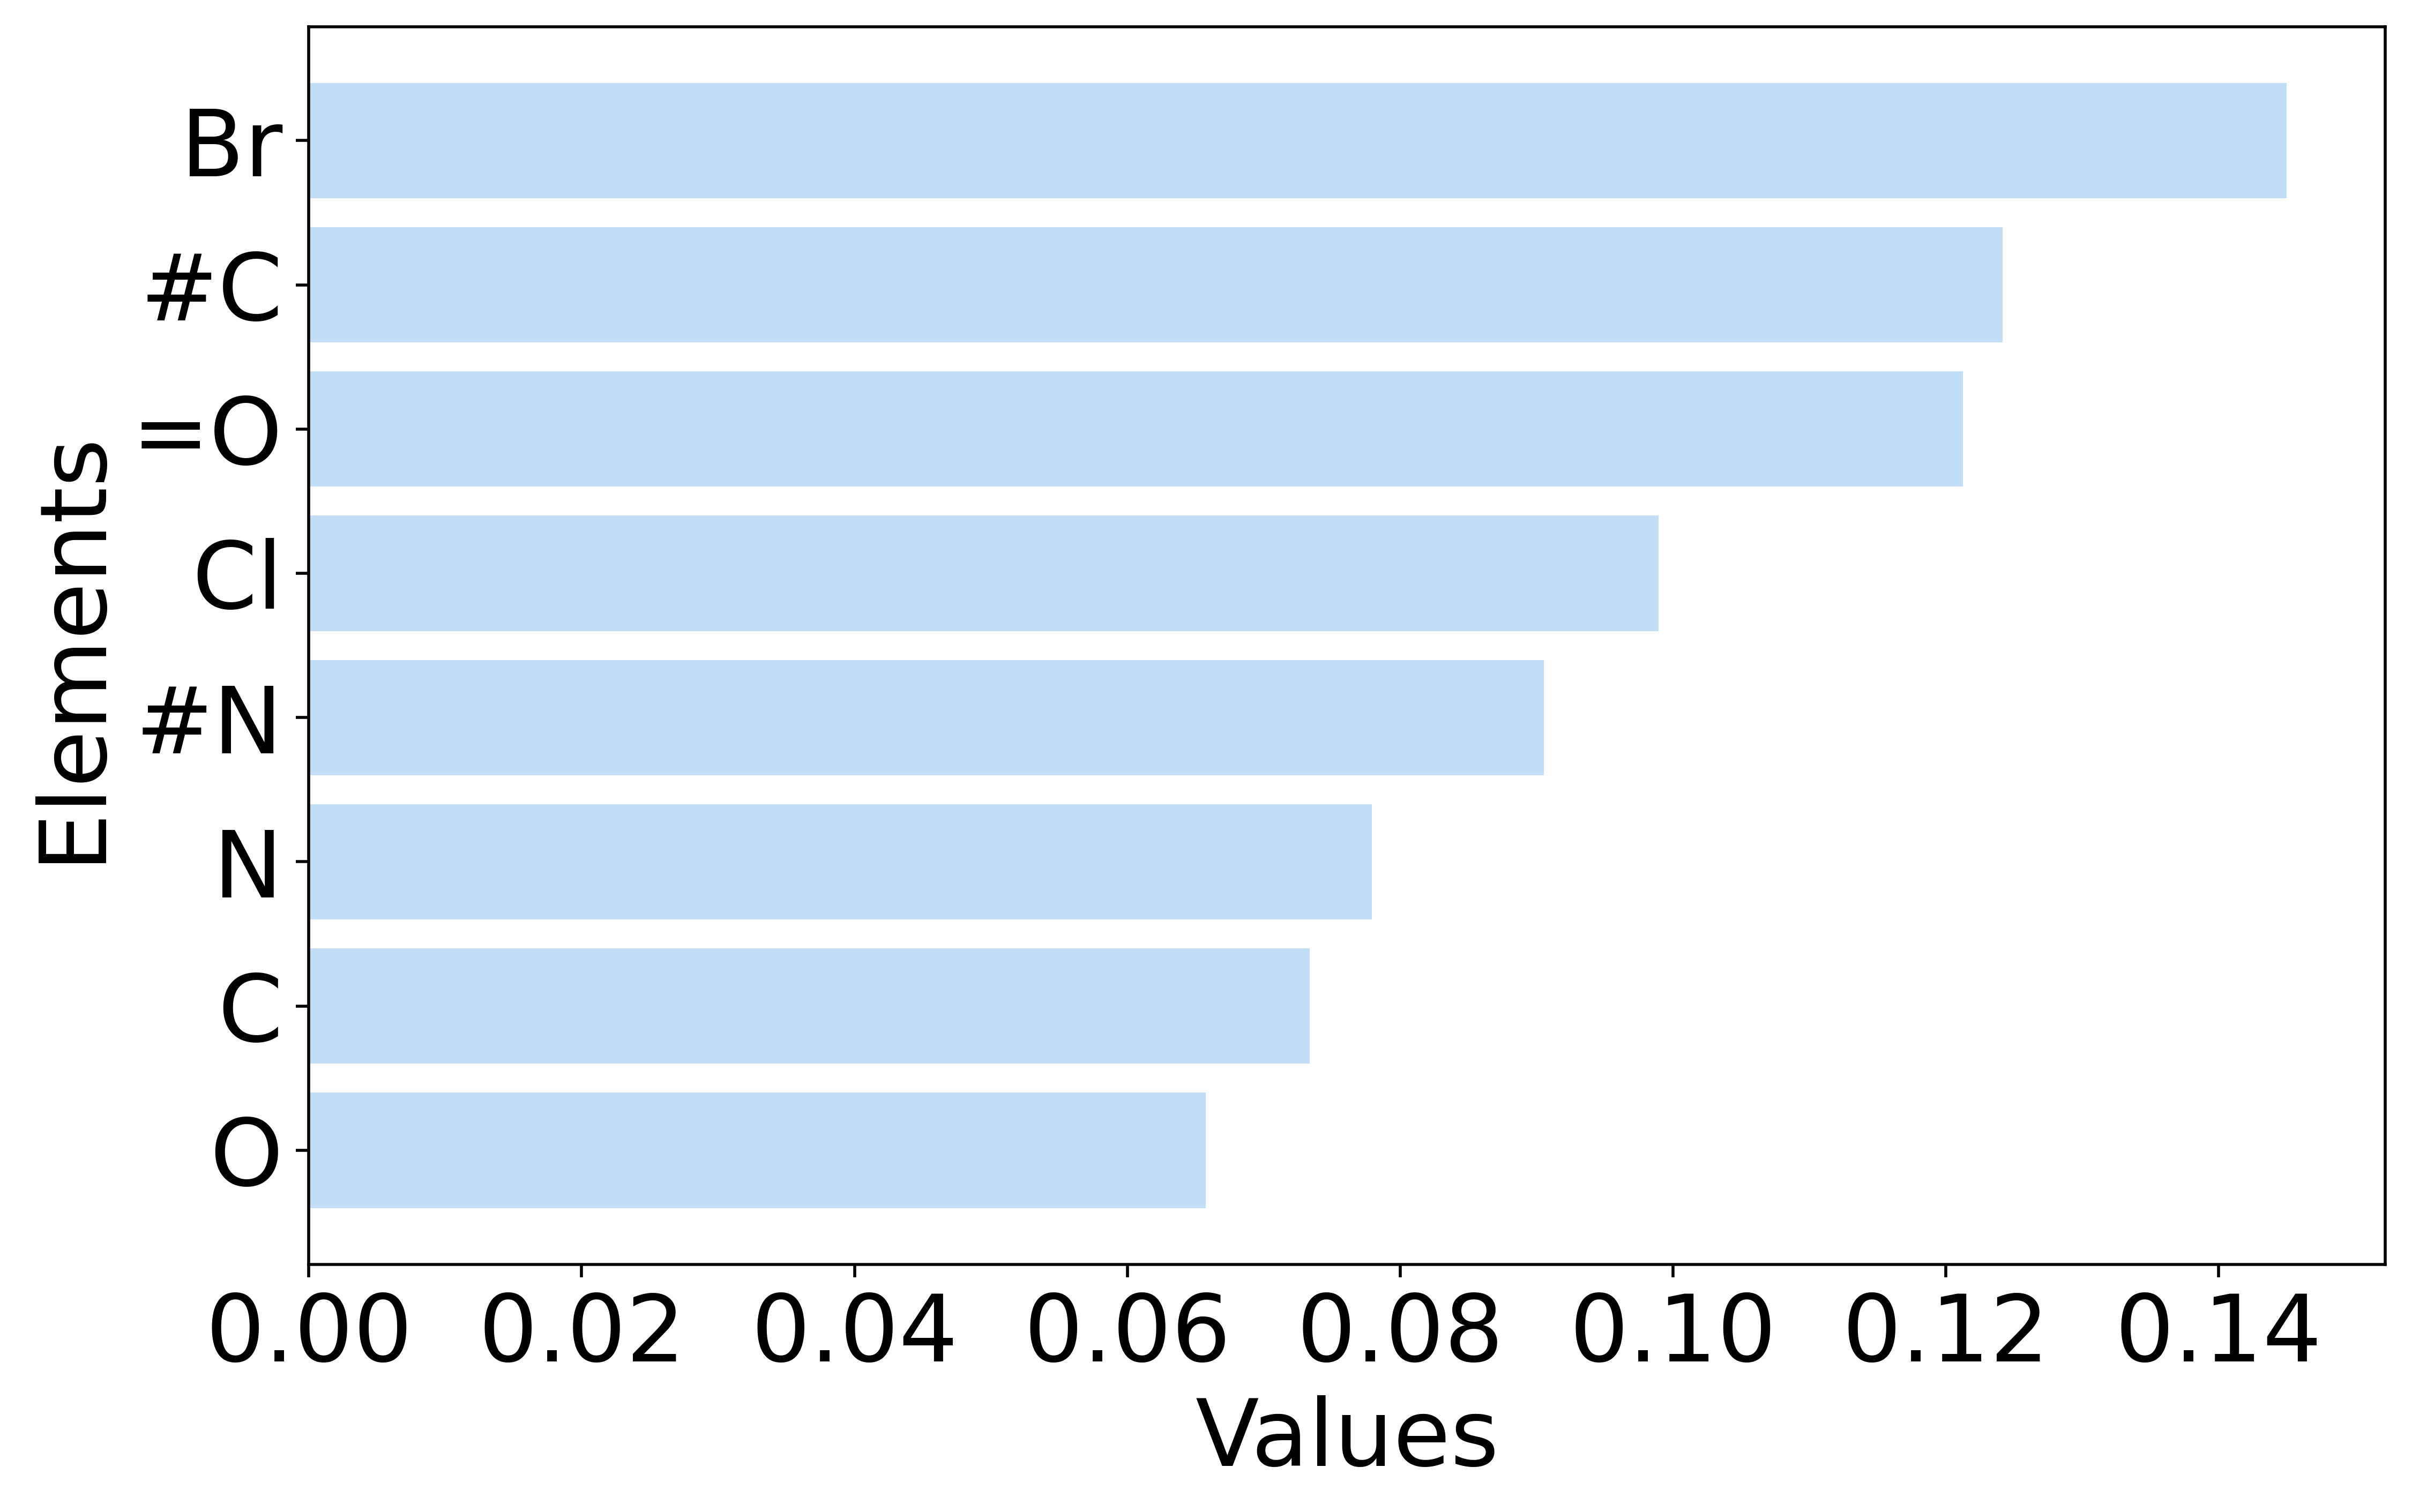

In [32]:
# 按值从大到小排序
sorted_indices = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
sorted_elements = [elements[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

# 绘制横向柱状图
plt.figure(figsize=(10, 6),dpi=500)
plt.barh(sorted_elements, sorted_values, color='#C1DEF6')

# 反转y轴，使最高值在最上方
plt.gca().invert_yaxis()
# 调整刻度字体大小
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# 添加标签和标题
plt.xlabel("Values",fontsize=25)
plt.ylabel("Elements", fontsize=25)
#plt.title("Sorted Horizontal Bar Chart of Element Values")

# 显示图表
plt.show()

In [ ]:
[C] : 0.07336026
[P] : 0.04085871
[O] : 0.06575617


[=O] : 0.12125614
[O-1] : 0.047443546
[=C] : 0.048272423

[Cl] : 0.09894753

[Br] : 0.14498705
[S] : 0.04854124



[#C] : 0.12415243
[=S] : 0.061400037
[F] : 0.06169526

[N+1] : 0.029231597
[#N] : 0.09054613
[N] : 0.07793074
[=N] : 0.06470954
[=N+1] : 0.015106926
[=N-1] : 0.02515692


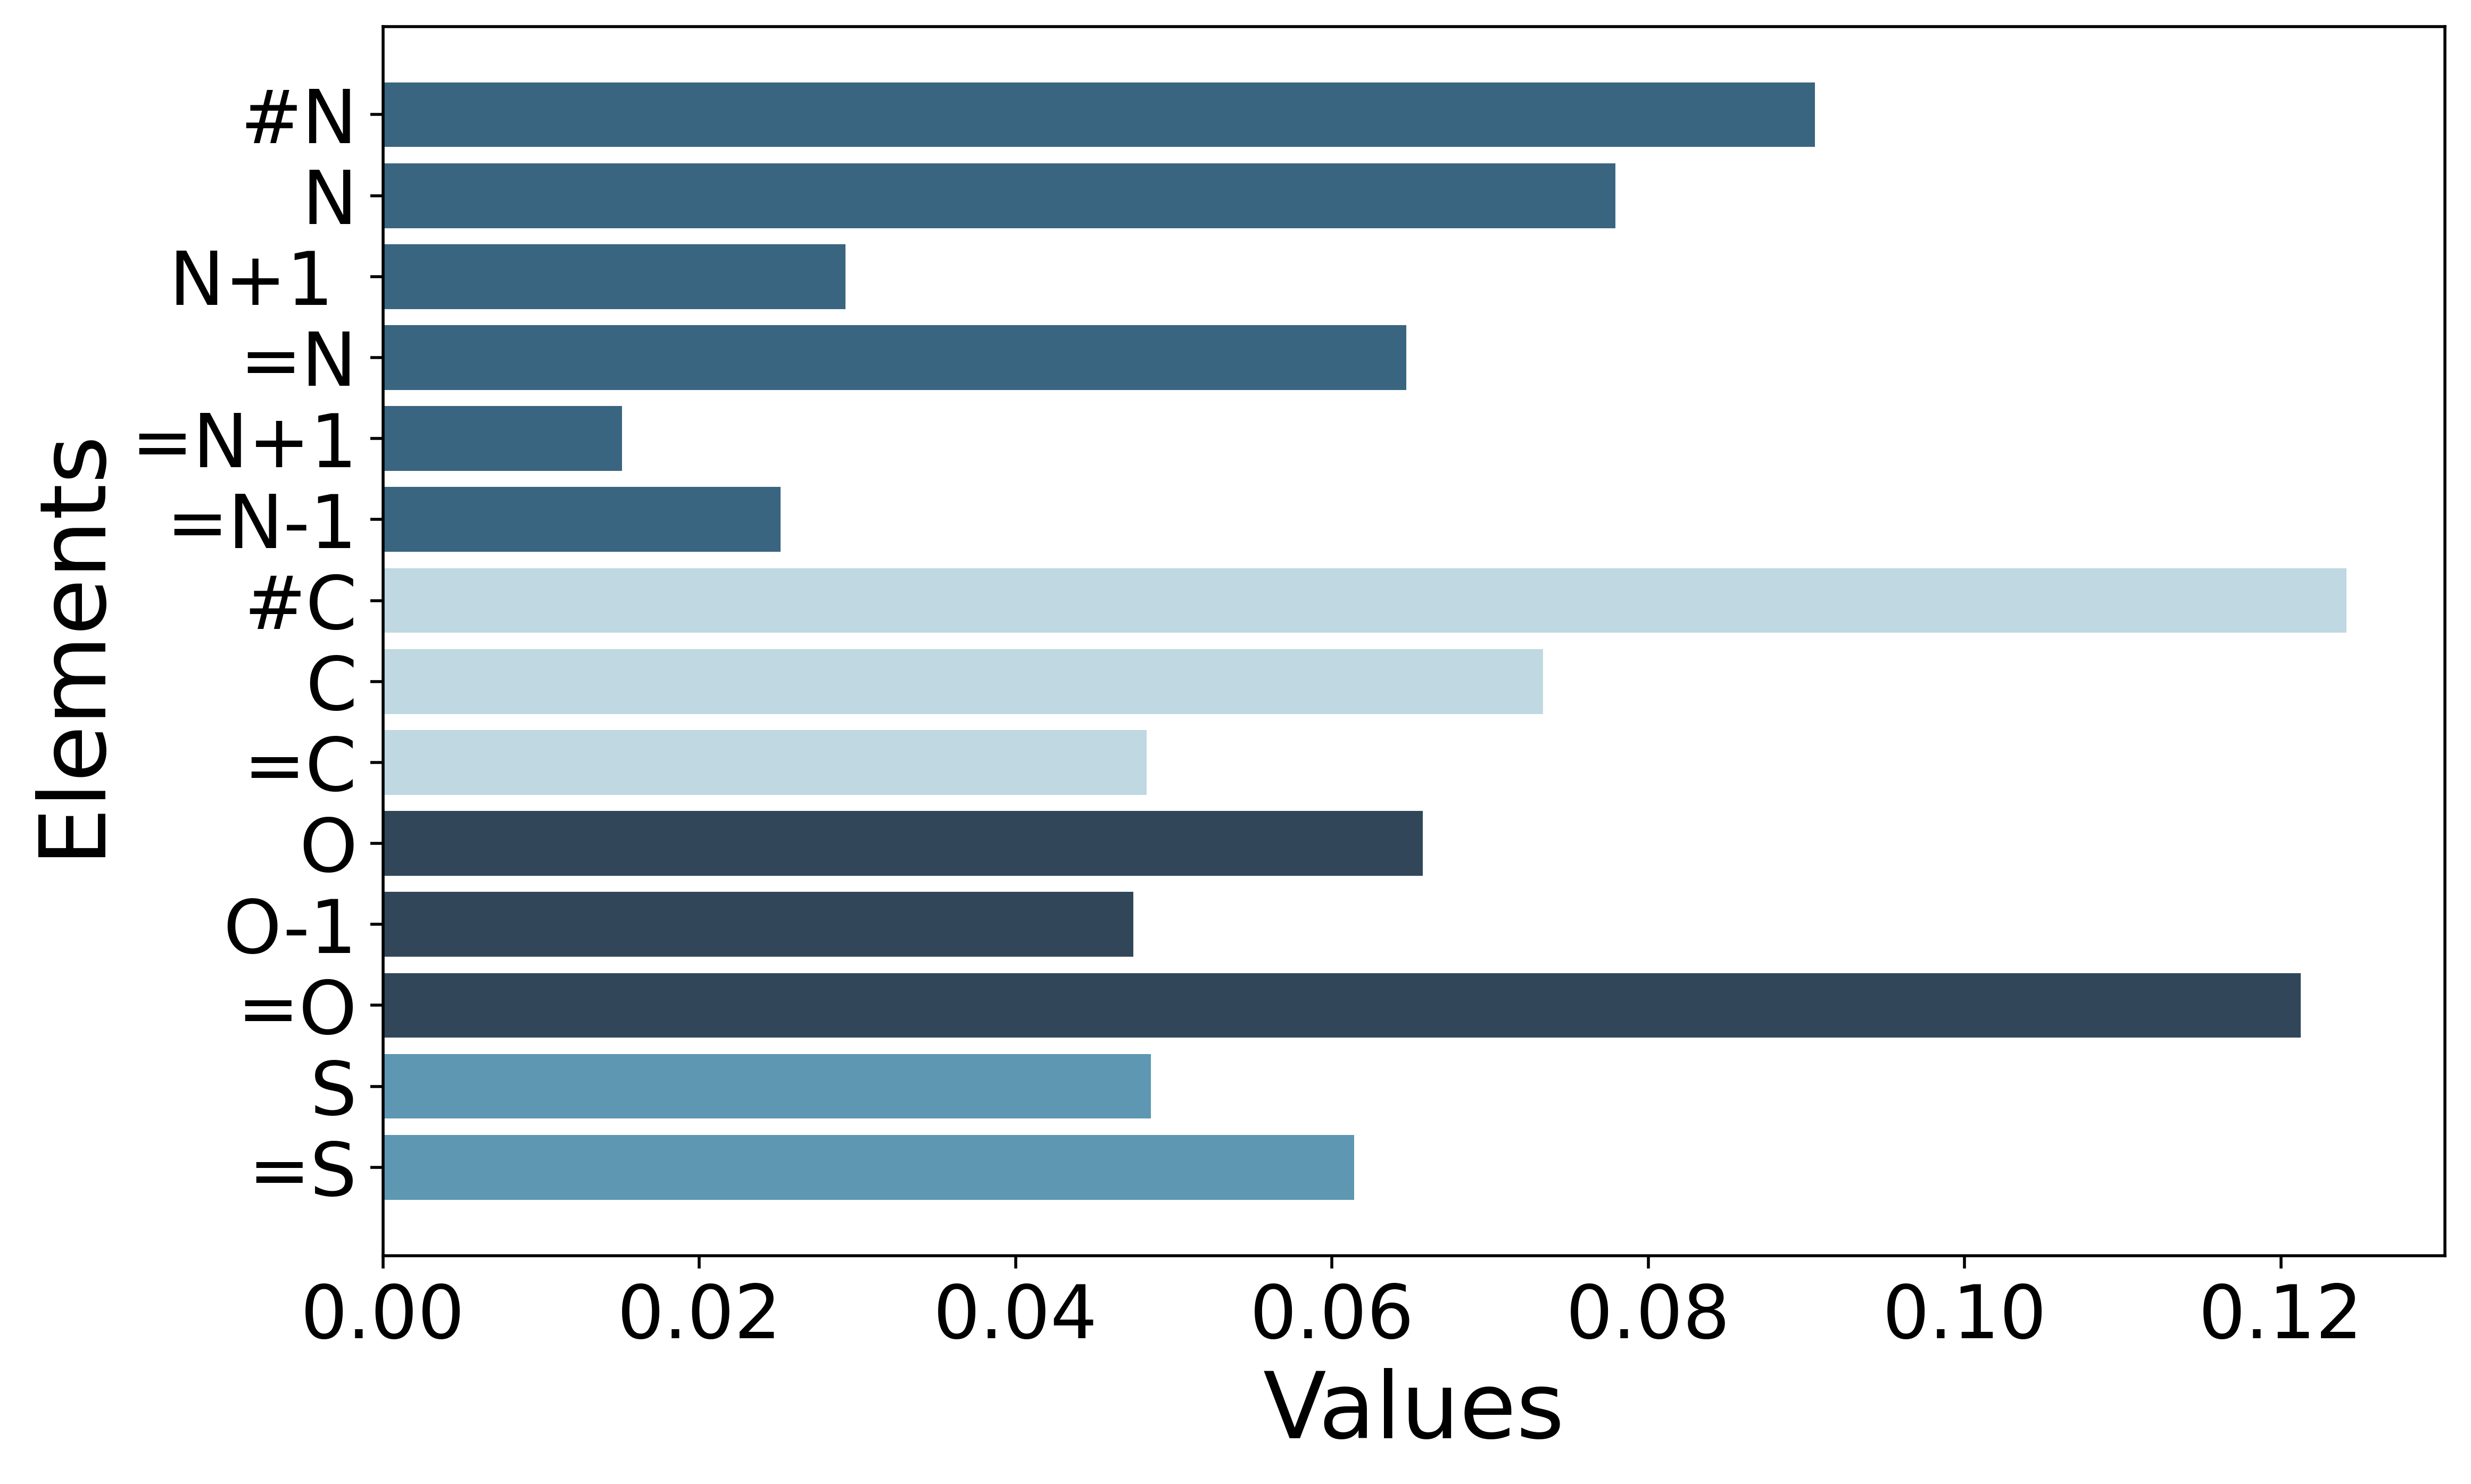

In [34]:
elements = ["#N", "N", "N+1 ", "=N", "=N+1", "=N-1",
            "#C","C","=C",
            "O","O-1","=O",
            "S","=S"]
values = [0.09054613, 0.07793074, 0.029231597, 0.06470954, 0.015106926, 0.02515692,
          0.12415243,0.07336026,0.048272423,
          0.06575617,0.047443546,0.12125614,
          0.04854124,0.061400037]


# [#N] : 0.10505723
# [N] : 0.08566408
# [N+1] : 0.049981248
# [=N] : 0.04332977
# [=N+1] : 0.03180132
# [=N-1] : 0.019939277
# [=C] : 0.040766984
# [C] : 0.06910326
# [#C] : 0.12494355
# [=O] : 0.06912473
# [O-1] : 0.069429986
# [O] : 0.078830585
# [S] : 0.111683786
# [=S] : 0.06254192

# 按值从大到小排序
#sorted_indices = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
#sorted_elements = [elements[i] for i in sorted_indices]
#sorted_values = [values[i] for i in sorted_indices]


# 颜色映射：根据原子类型分类
color_map = {
    "N": "#3A6580",   # 红色（氮）
    "C": "#BFD8E2",   # 蓝色（碳）
    "O": "#314759",   # 绿色（氧）
    "S": "#5E97B2"    # 黄色（硫）
}

# 生成颜色列表
colors = [color_map["N"] if "N" in el else color_map["C"] if "C" in el else color_map["O"] if "O" in el else color_map["S"] for el in elements]

# 绘制横向柱状图
plt.figure(figsize=(10, 6), dpi=500)
plt.barh(elements, values, color=colors)




# # 绘制横向柱状图
# plt.figure(figsize=(10, 6),dpi=500)
# plt.barh(elements, values, color='#6A7FC1')

# 反转y轴，使最高值在最上方
plt.gca().invert_yaxis()
# 调整刻度字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# 添加标签和标题
plt.xlabel("Values",fontsize=25)
plt.ylabel("Elements", fontsize=25)
#plt.title("Sorted Horizontal Bar Chart of Element Values")

# 显示图表
plt.show()





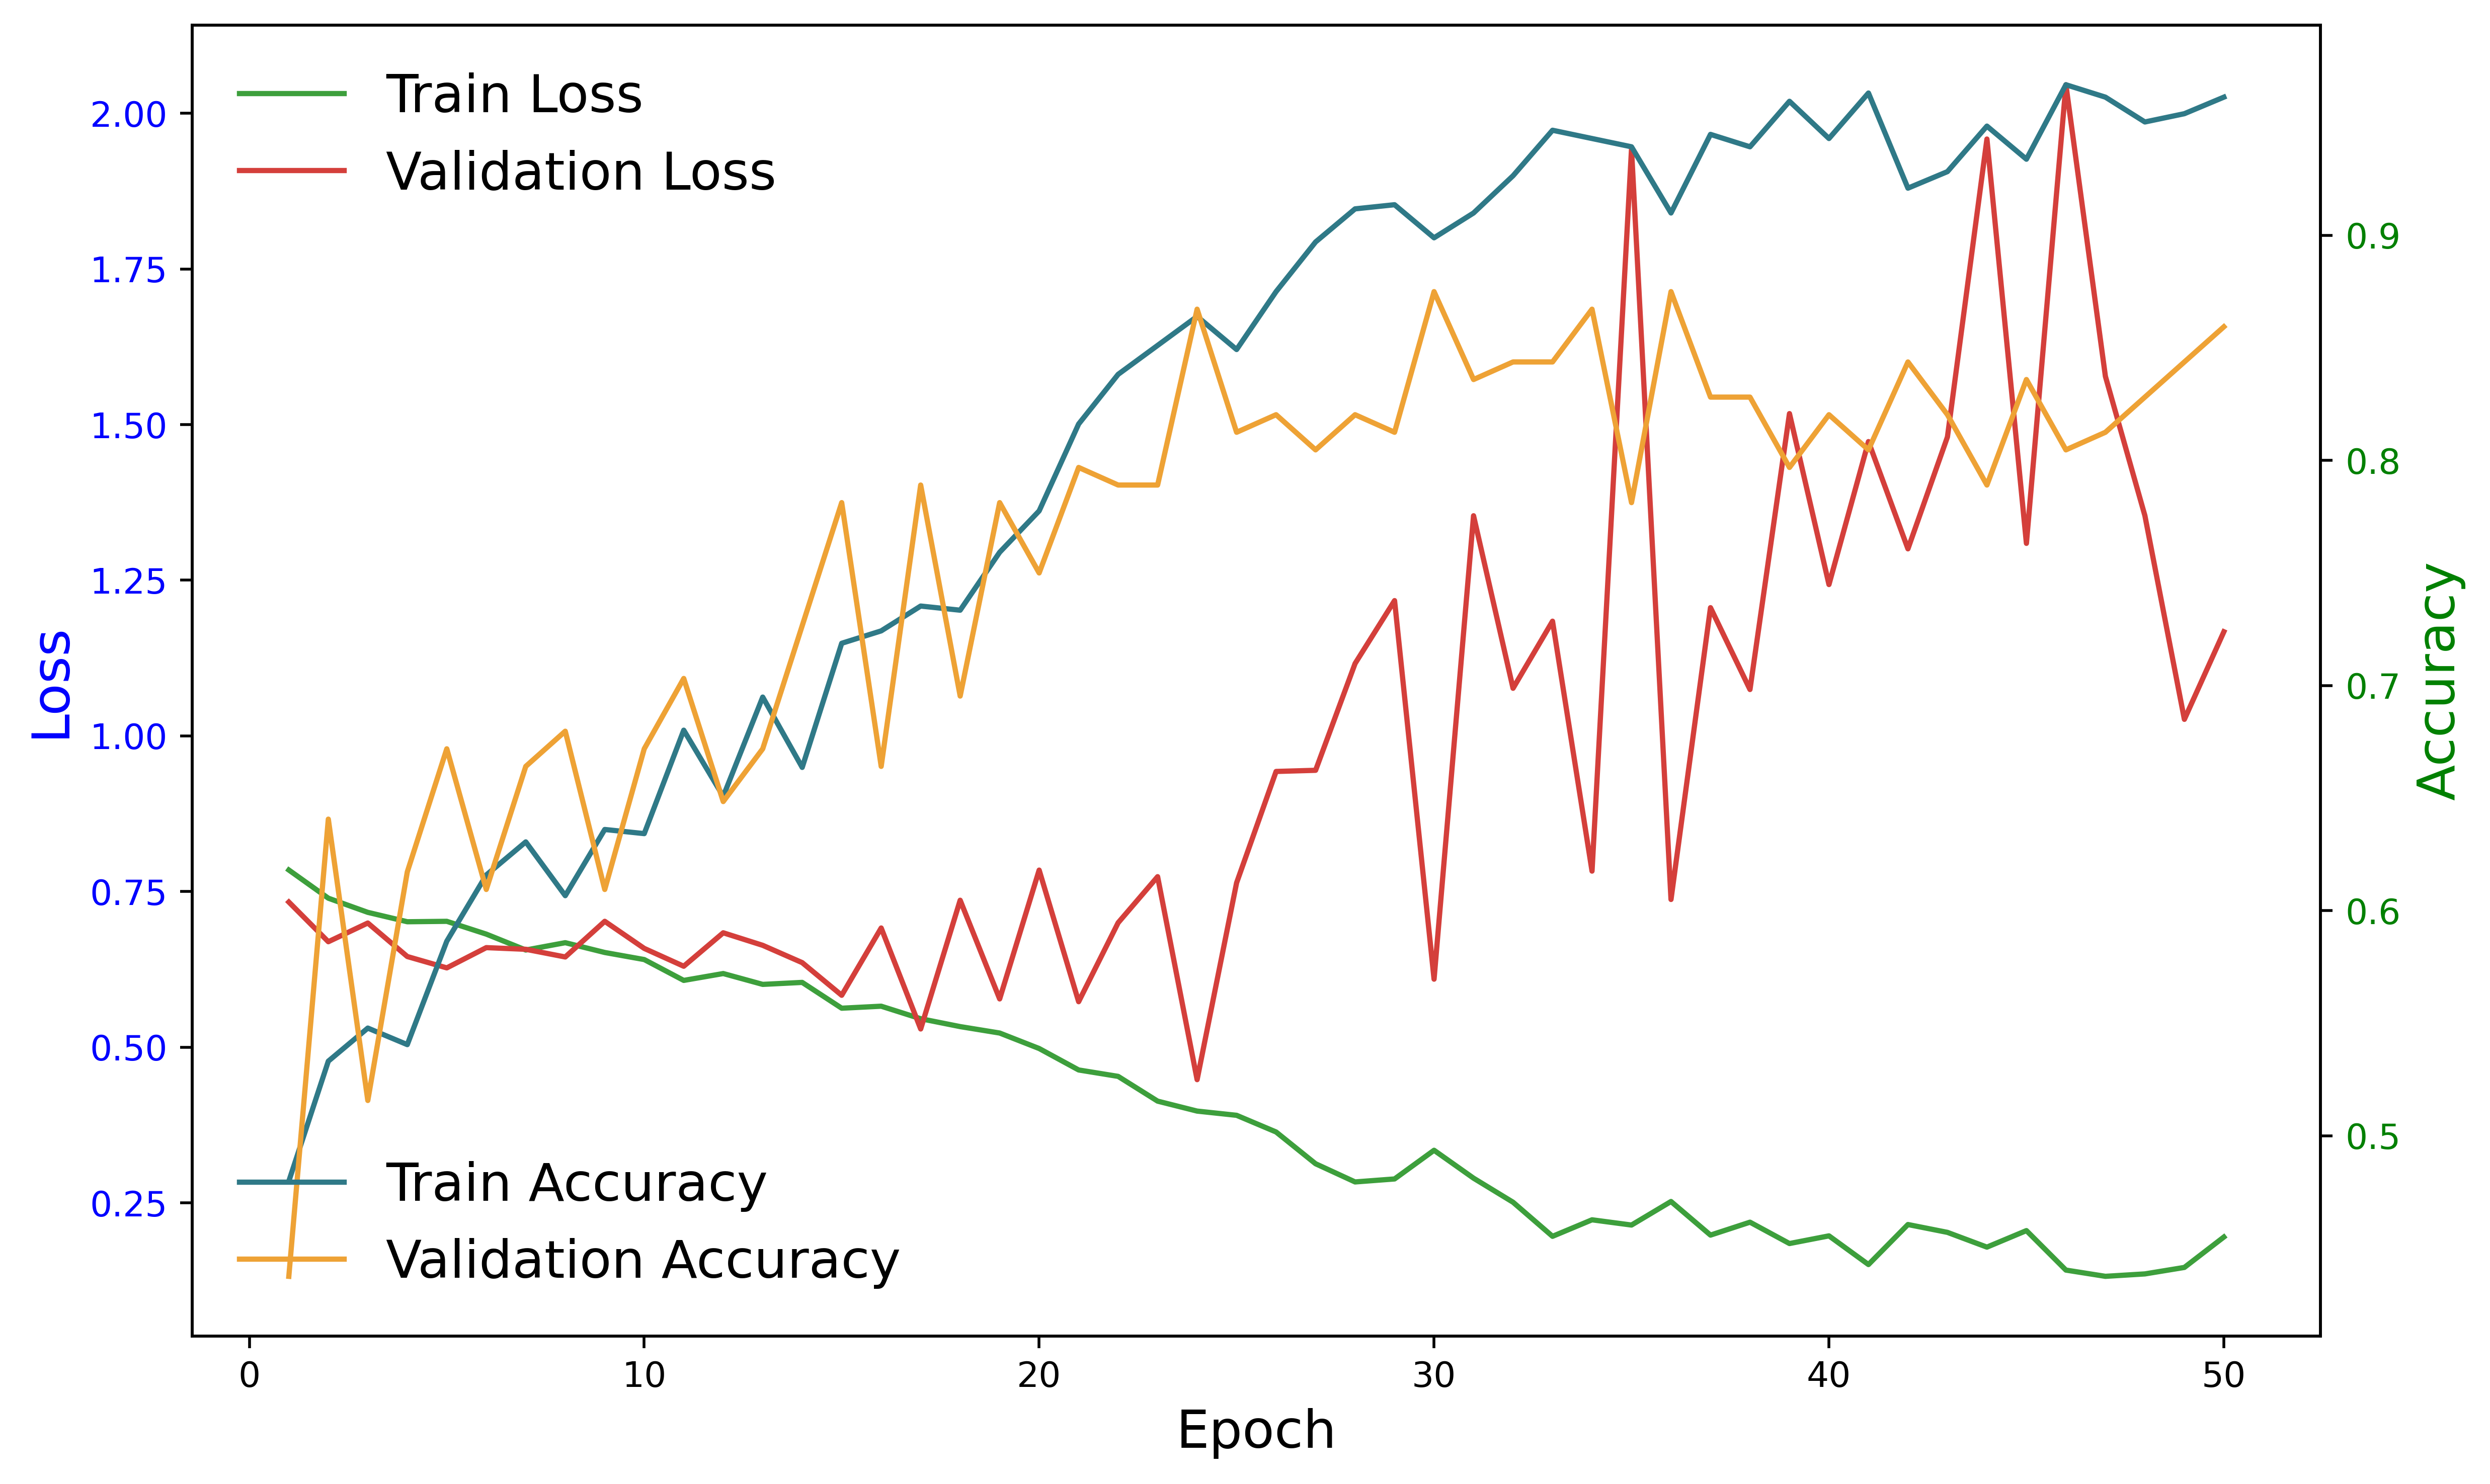

In [21]:

'''
# 读取保存的CSV文件
df = pd.read_csv('training_metrics.csv')

# 提取数据
num_epochs = 50
train_losses = df['Train Loss']
val_losses = df['Val Loss']
train_accuracies = df['Train Accuracy']
val_accuracies = df['Val Accuracy']
'''
import matplotlib.pyplot as plt

# 创建一个新的图形
plt.figure(figsize=(10, 6),dpi=500)

# 绘制损失曲线
ax1 = plt.gca()  # 获取当前坐标轴
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='#3D9F3C')
ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='#D43F3B')
ax1.set_xlabel('Epoch', fontsize=15)
ax1.set_ylabel('Loss', color='blue', fontsize=15)
ax1.tick_params(axis='y', labelcolor='blue')  # 设置y轴的刻度颜色
#ax1.set_title('Loss and Accuracy Curve')

# 创建第二个y轴来绘制准确率曲线
ax2 = ax1.twinx()  # 创建第二个Y轴共享X轴
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='#2F7987')
ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='#EEA235')
ax2.set_ylabel('Accuracy', color='green', fontsize=15)
ax2.tick_params(axis='y', labelcolor='green')  # 设置y轴的刻度颜色

# 添加图例
ax1.legend(loc='upper left', frameon=False,fontsize=15)
ax2.legend(loc='lower left', frameon=False,fontsize=15)

# 显示图形
plt.tight_layout()
plt.show()

In [23]:
torch.save(model.state_dict(), 'best_chemberta_model.pth')

In [84]:
# 加载最佳模型
model.load_state_dict(torch.load('./best_chemberta_model.pth'))

<All keys matched successfully>

In [24]:


# 提取 SMILES 的嵌入表示

# 提取 SMILES 的嵌入表示
def extract_embeddings(smiles_list, model, tokenizer, device):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for smiles in smiles_list:
            # 编码 SMILES
            tokens = tokenizer(smiles, padding='max_length', truncation=True, max_length=10, return_tensors="pt")
            # 将所有张量移动到指定设备上（例如 GPU）
            tokens = {key: val.to(device) for key, val in tokens.items()}
            
            # 通过 ChemBERTa 模型获得输出
            outputs = model.chemberta(**tokens)
            
            # 提取 [CLS] token 的嵌入作为 SMILES 的整体嵌入
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embedding)
    
    return np.vstack(embeddings)

# 提取嵌入
smiles_embeddings = extract_embeddings(smiles_data, model, tokenizer_instance, device)

In [25]:
np.save('./Toxicity_smiles_embeddings.npy',smiles_embeddings)

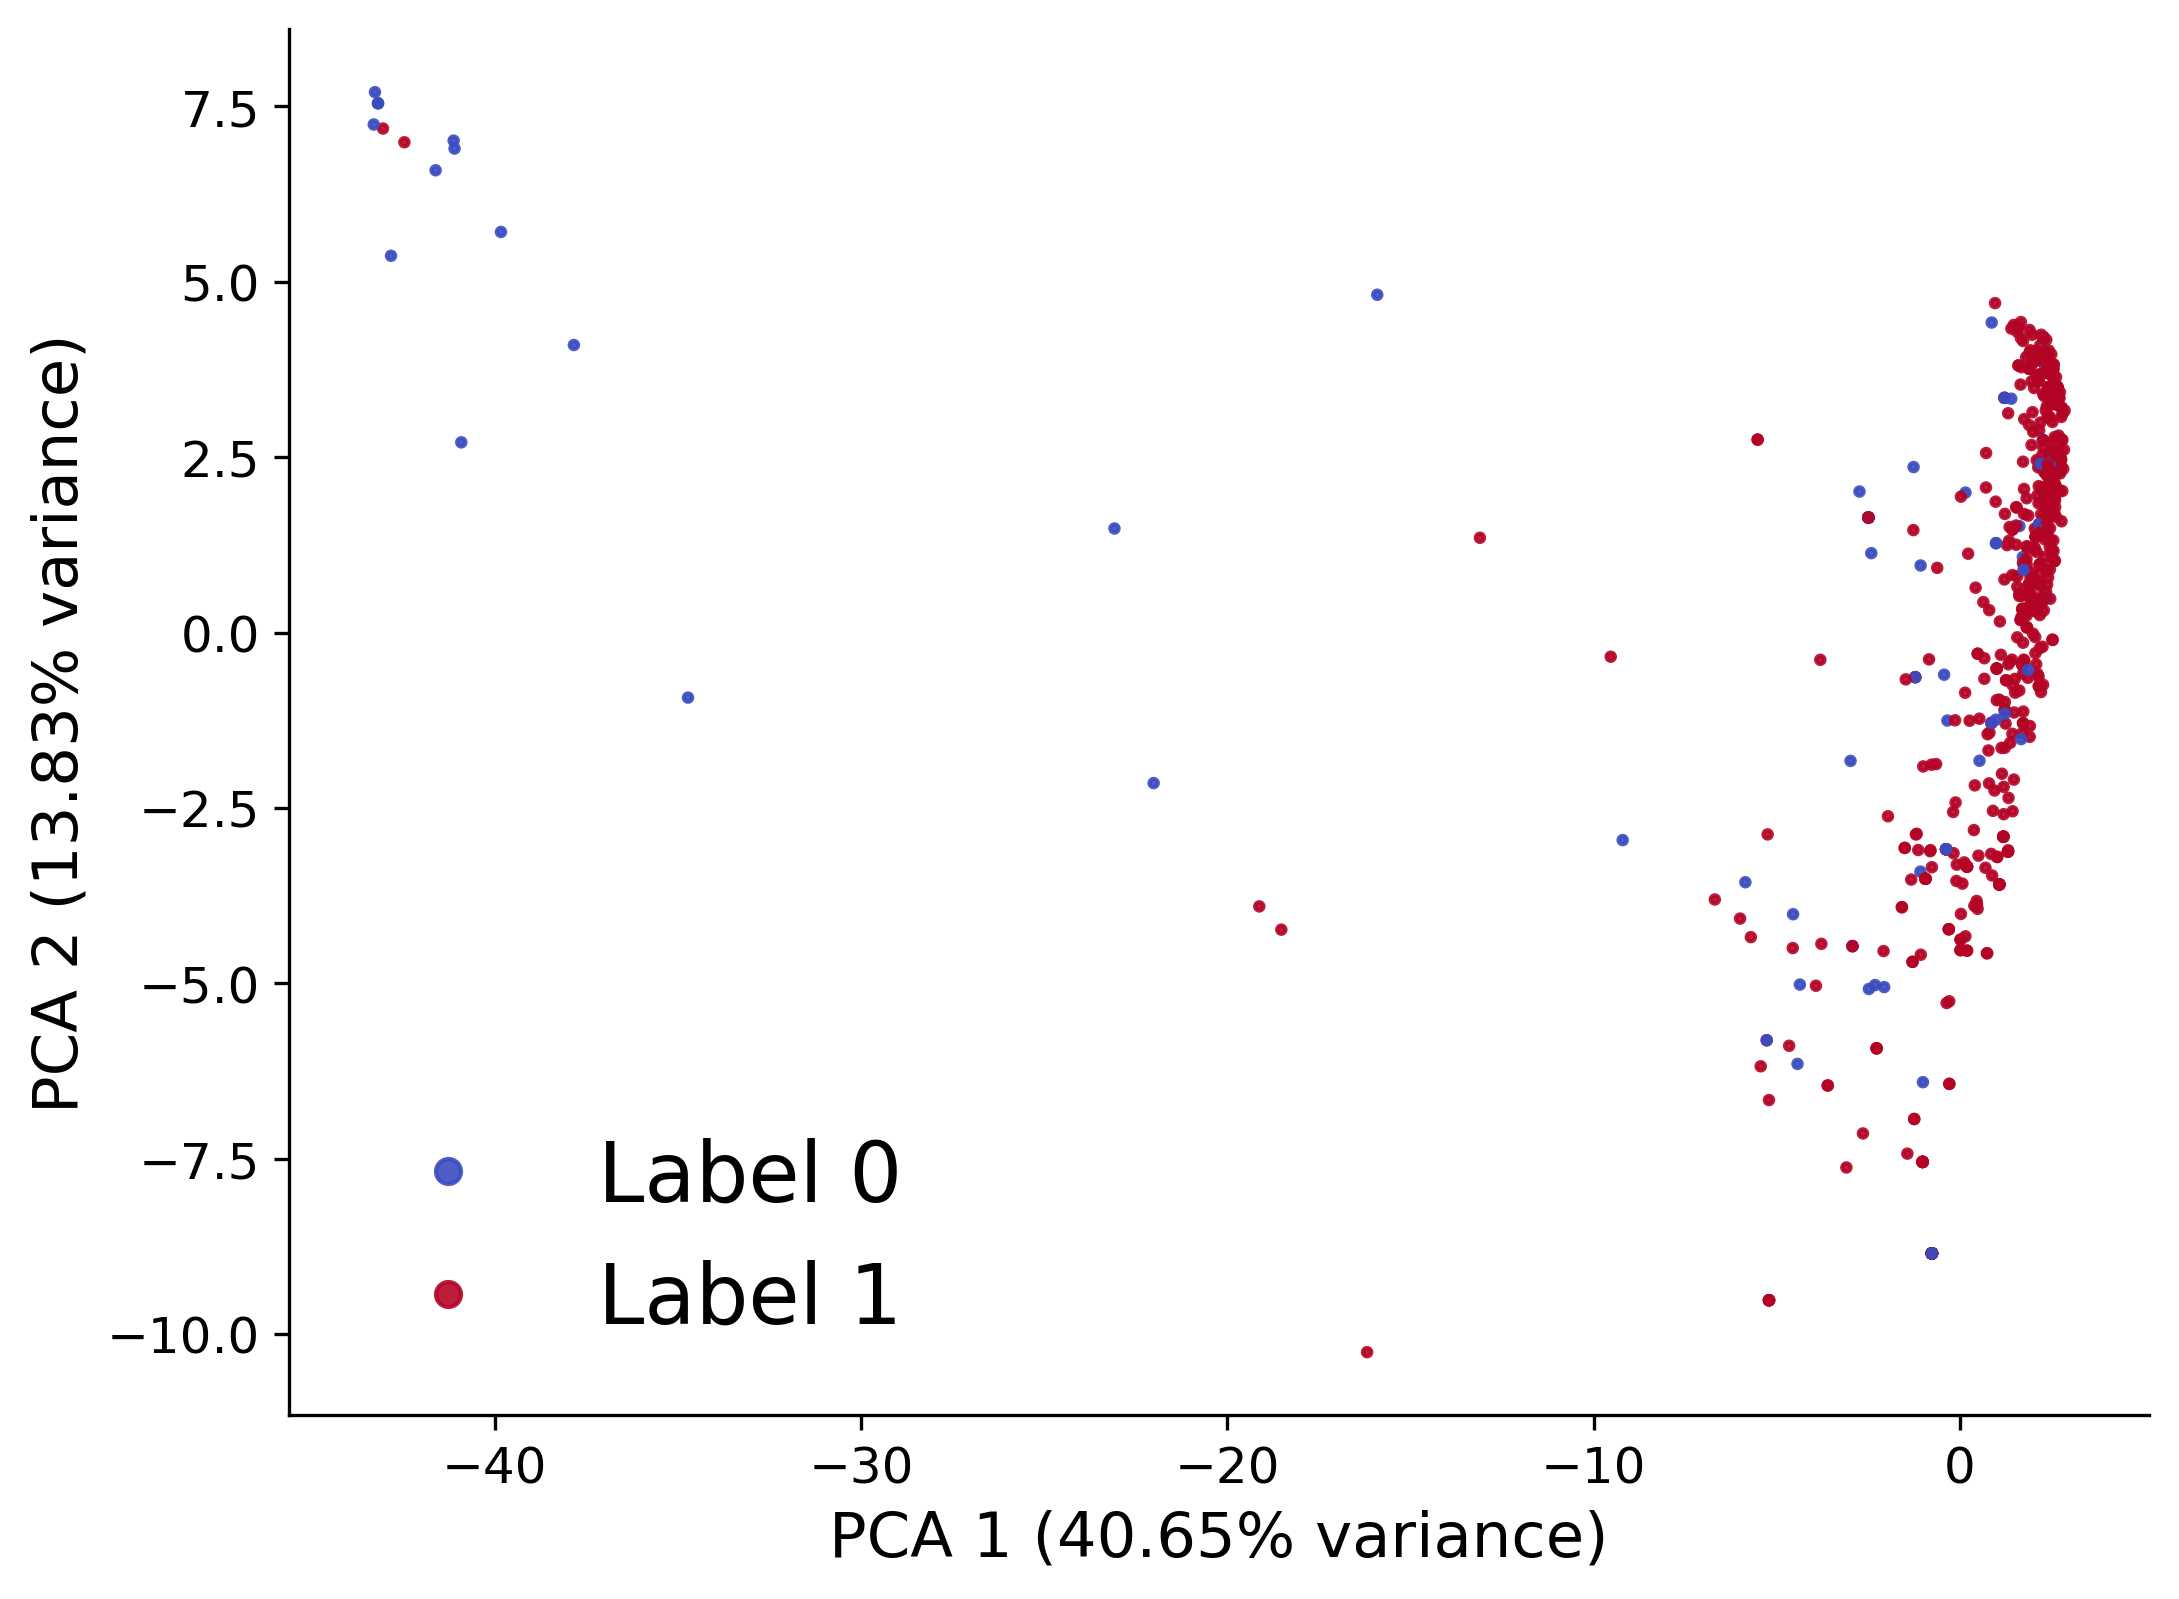

In [26]:
# 使用 PCA 对嵌入进行降维，同时获取主成分的解释方差百分比
def apply_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_  # 获取每个主成分的解释方差
    return pca_result, explained_variance


# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=4)

    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=20,frameon=False)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()



# 使用 PCA 降维，并获取解释方差
pca_result, explained_variance = apply_pca(smiles_embeddings, n_components=2)

# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, labels, explained_variance)

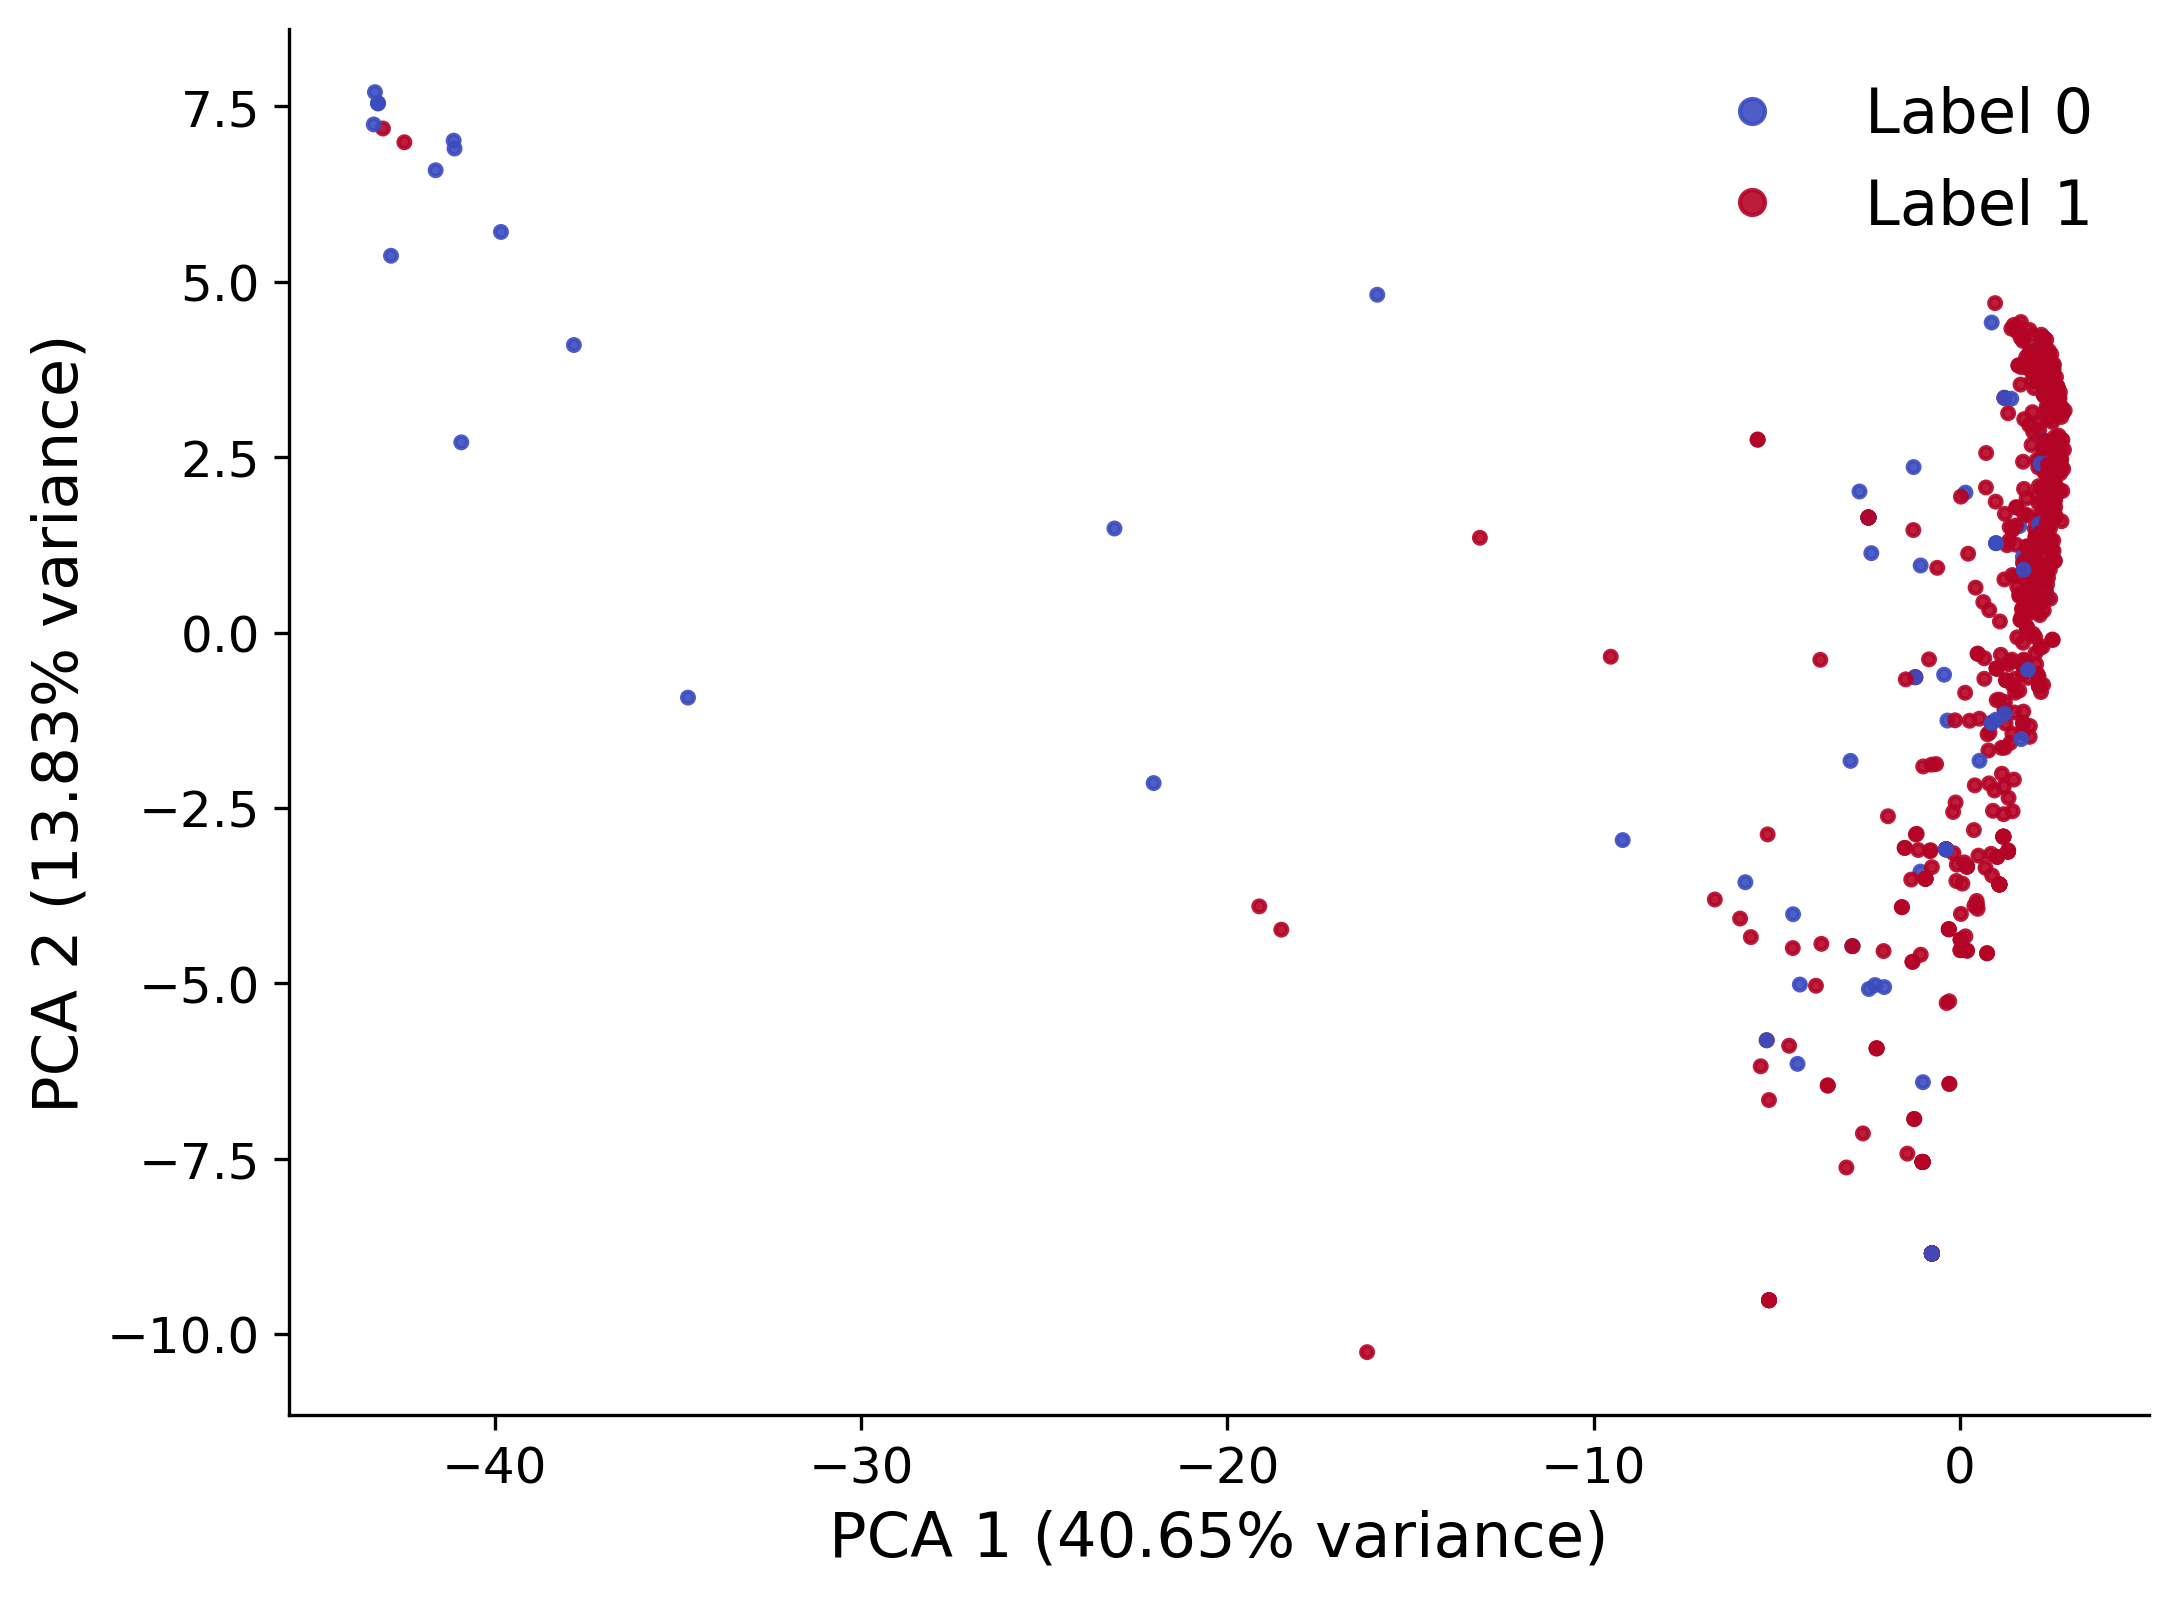

In [27]:
# 可视化函数，同时显示解释方差百分比
def plot_pca_with_variance(pca_result, labels, explained_variance):
    plt.figure(figsize=(8, 6), dpi=300)
    
    # 为 labels 只有 0 和 1 两个值指定两个颜色
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=8)

    plt.xlabel(f'PCA 1 ({explained_variance[0]*100:.2f}% variance)', fontsize=15)
    plt.ylabel(f'PCA 2 ({explained_variance[1]*100:.2f}% variance)', fontsize=15)

    # 添加图例，手动指定标签
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=15,frameon=False)
    
    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 隐藏左侧框线
    ax.spines['right'].set_visible(False)  # 隐藏底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    plt.show()


# 绘制 PCA 图，并显示每个主成分的解释方差百分比
plot_pca_with_variance(pca_result, labels, explained_variance)

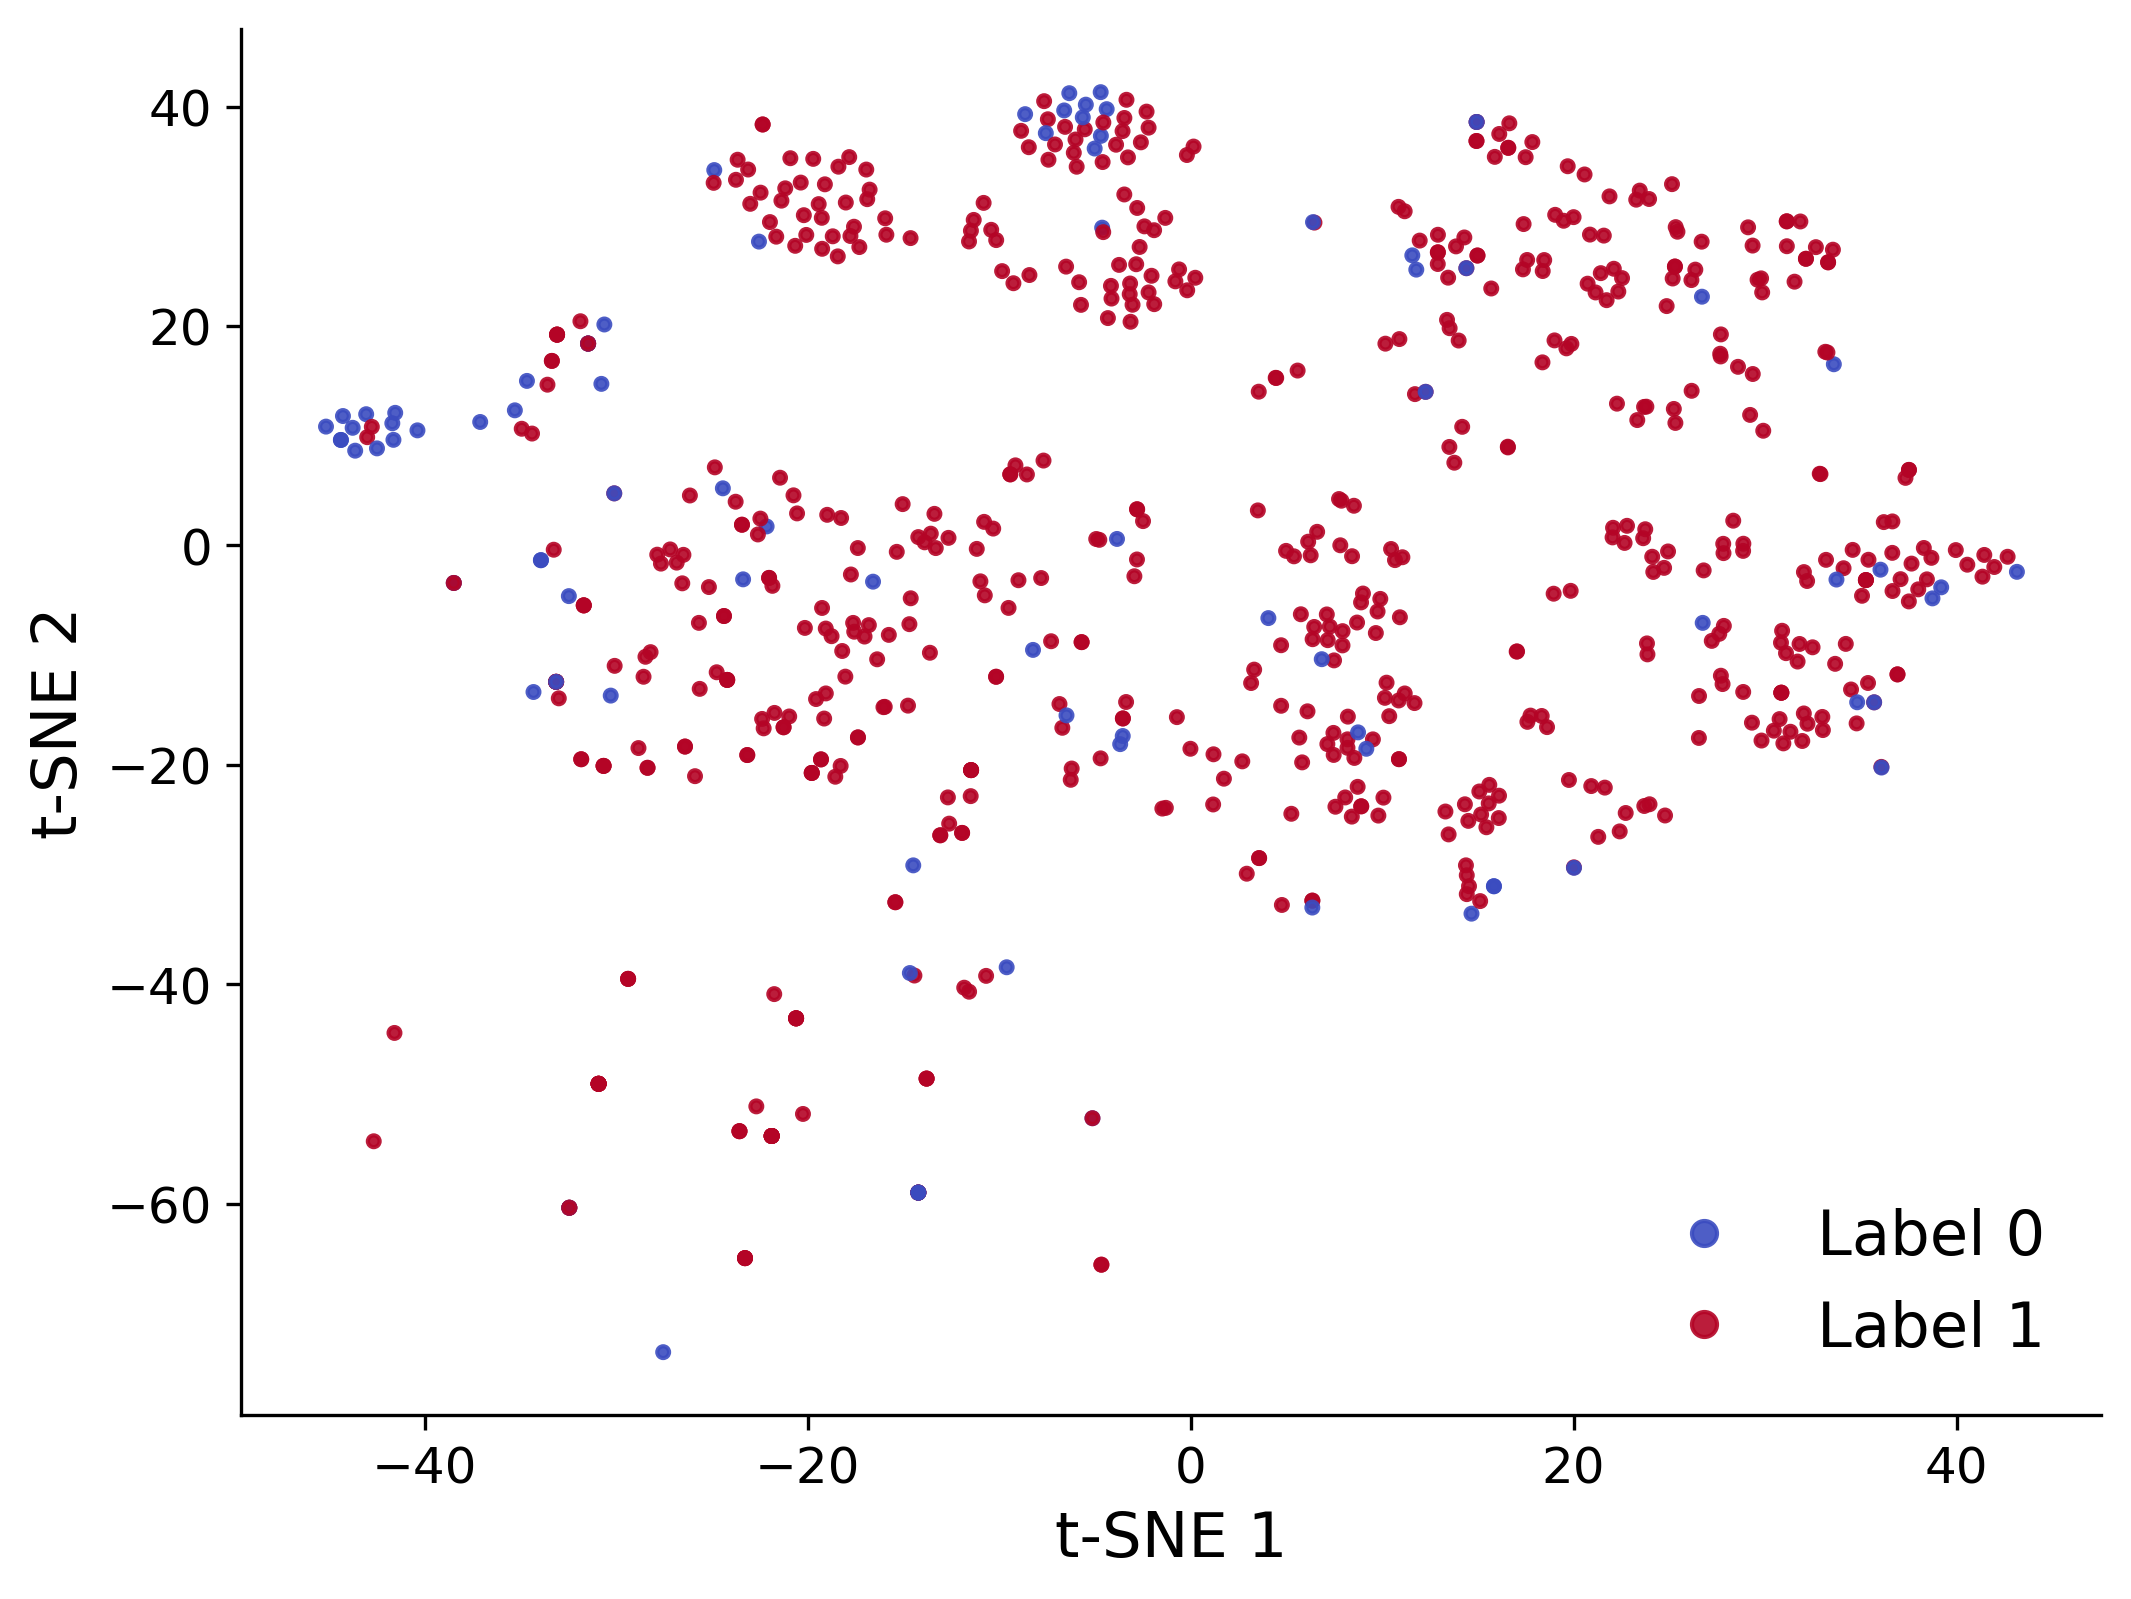

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import font_manager



# 使用 t-SNE 对嵌入进行降维，同时获取每个主成分的解释方差百分比
def apply_tsne(embeddings, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

def plot_tsne_with_variance(tsne_result, labels):
    plt.figure(figsize=(8, 6),dpi=300)
    
    # 绘制散点图，使用 'coolwarm' colormap，labels 作为着色依据
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.9, s=8)

    # 添加 colorbar
    #cbar = plt.colorbar(scatter)
    #cbar.set_label('lables', fontsize=15, fontproperties=prop)  # 设置 colorbar 的字体大小
    plt.legend(handles=scatter.legend_elements()[0], labels=['Label 0', 'Label 1'], loc='best', fontsize=15,frameon=False)
    
    # 设置坐标轴标签
    plt.xlabel('t-SNE 1', fontsize=15)
    plt.ylabel('t-SNE 2', fontsize=15)

    # 获取当前坐标轴对象
    ax = plt.gca()

    # 设置所有边框的可见性，并确保框线颜色正常显示
    ax.spines['top'].set_visible(True)    # 显示顶部框线
    ax.spines['right'].set_visible(True)  # 显示右侧框线
    ax.spines['top'].set_color('black')   # 设置顶部框线颜色为黑色
    ax.spines['right'].set_color('black') # 设置右侧框线颜色为黑色
    ax.spines['top'].set_linewidth(1.5)   # 设置顶部框线的宽度
    ax.spines['right'].set_linewidth(1.5) # 设置右侧框线的宽度

    # 让其余边框可见（通常默认已可见）
    ax.spines['top'].set_visible(False)  # 显示左侧框线
    ax.spines['right'].set_visible(False)  # 显示底部框线
    
    ax.tick_params(axis='both', labelsize=12)  # 设置x轴和y轴刻度标签的字体大小为12

    # 显示图形
    plt.show()




# 使用 t-SNE 降维
tsne_result = apply_tsne(smiles_embeddings, n_components=2)

# 绘制 t-SNE 图
plot_tsne_with_variance(tsne_result, labels)


In [21]:
np.save('./CLS_smiles_embeddings.npy', smiles_embeddings)

In [ ]:
#val_r2 = r2_score(np.expm1(all_labels), np.expm1(all_preds))  # 还原 log1p 的值